In [3]:
# Import standard libraries
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from scipy.integrate import solve_ivp
from scipy.ndimage import gaussian_filter
from scipy.optimize import fsolve, leastsq,root,brentq,newton,curve_fit
from sympy.utilities.lambdify import lambdify
from sympy import sympify
from sympy import var

import timeit
from time import time
from mpl_toolkits import mplot3d

# Set matplotlib parameters for consistent figure styling
plt.rcParams.update({
    "font.family": "STIXGeneral",
    "xtick.labelsize": 12,
    "xtick.direction": "in",
    "xtick.major.pad": 3,
    "xtick.top": True,
    "ytick.labelsize": 12,
    "ytick.direction": "in",
    "ytick.right": True,
    "axes.labelsize": 12,
    "axes.labelpad": 3,
    "axes.grid": True,
})

# Constants
E0 = 8.85e-12
e = 1.6e-19
m = 6.64215627e-26
pi = math.pi
h_bar = 1.0546e-34

# Parameters for the simulation
T_factor = (121 / 133.93969396934) * 1.1625  # The time factor for the simulation
voltage_change_factor = 1.00  # The factor to change the voltage
NUM_VOLTAGE_POINTS = 500  # The points for voltage sampling
T = 150 * 1e-6 * T_factor # Total time duration in s unit
points = 3000000  # Number of points at which to evaluate the solution
method = 'RK45'

Length of time_array: 1000, Length of scaled_voltage_array: 1000
scaled_voltage_array_min = 23.33, scaled_voltage_array_max = 28.68
First 5 elements of time_array: [0.070641   0.22762099 0.38460099 0.54158099 0.69856098]
First 5 elements of scaled_voltage_array: [23.84085696 23.97000888 24.08911701 24.19851578 24.29853392]
The time range =  156.89365671643444  us


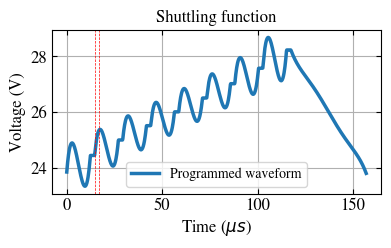

The initial position:  -7.149809623038499e-06
The trap frequency:  1189543.8529271574
[np.float64(-43.278248906313934), np.float64(-32.62193236993827), np.float64(-23.58759843933837), np.float64(-15.231820183755104), np.float64(-7.149809623038499), np.float64(0.9322009376781054), np.float64(9.287979193261375), np.float64(18.322313123861274), np.float64(28.978629660236937), 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
1189543.8529271574 -7.149809623038499e-06
-17.143096774869548
-6.484979143113785
2.550819921816262
10.908128859113368
18.991461398394726
27.07479393767608
35.43210287497316
44.46790193990327
55.12601957165901
3000000


KeyboardInterrupt: 

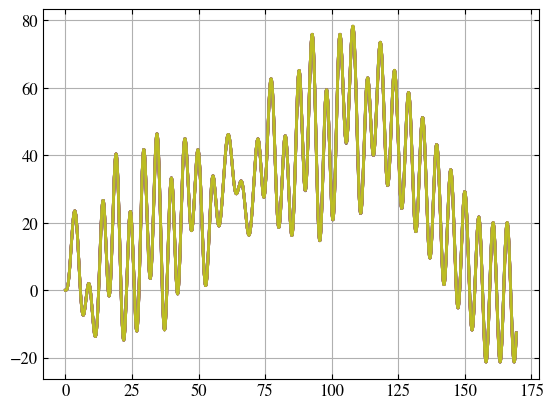

In [4]:
def pfit(x_data, y_data, degree, plot=False):
    """
    Polynomial fit of data.

    Parameters:
    - x_data: x data points
    - y_data: y data points
    - degree: Degree of the polynomial
    - plot: Boolean to plot the original data and the fit

    Returns:
    - coeffs: Coefficients of the polynomial fit
    """
    coeffs = np.polyfit(x_data, y_data, degree)
    poly = np.poly1d(coeffs)
    y_fit = poly(x_data)
    if plot:
        plt.plot(x_data, y_data, label='Original')
        plt.plot(x_data, y_fit, label='Fit')
        plt.legend()
        plt.show()
    return coeffs

def v_har(delta_x, x_data, y_data, plot=False):
    """
    Harmonic fit around a minimum point within a specified range.

    Parameters:
    - delta_x: Range around the minimum point to consider for the fit
    - x_data: x data points
    - y_data: y data points
    - plot: Boolean to plot the original data and the fit

    Returns:
    - coeffs: Coefficients of the polynomial fit
    """
    def mini(x_data, y_data):
        """Find the minimum point of the potential."""
        min_index = np.argmin(y_data)
        return x_data[min_index]

    min_x = mini(x_data, y_data)
    mask = (x_data >= min_x - delta_x) & (x_data <= min_x + delta_x)
    fit_x_data = x_data[mask]
    fit_y_data = y_data[mask]

    coeffs = np.polyfit(fit_x_data, fit_y_data, 2)  # Degree is always 2 for harmonic fit
    poly = np.poly1d(coeffs)
    y_fit = poly(x_data)

    if plot:
        plt.plot(x_data, y_data, label='Original')
        plt.plot(x_data, y_fit, label='Fit')
        plt.xlabel('x/m')
        plt.ylabel('Potential Energy/J')
        plt.legend()
        plt.show()

    return coeffs

def scale_voltage_array(voltage_array, original_min, original_max, new_min, new_max):
    """Scales the voltage array based on the original and new min/max values."""
    return ((voltage_array - original_min) / (original_max - original_min)) * (new_max - new_min) + new_min

def load_and_process_data(filepath, smooth = False, smooth_window = 100):
    """Loads the CSV, processes the data, and saves time and scaled voltage arrays."""
    # Load the CSV file
    df = pd.read_csv(filepath)
    if(smooth == True):
        df = df.groupby(np.arange(len(df)) // smooth_window).mean()

    # Extract arrays of time and voltage, apply scaling and corrections
    time_array = df['Time (us)'].to_numpy() * T_factor * 1e6
    voltage_array = df['Value'].to_numpy() * (-0.0682 * 1e6) + 20.17
    
    # Scale the first voltage array
    original_min, original_max = min(voltage_array), max(voltage_array)
    scaled_voltage_array = scale_voltage_array(voltage_array, original_min, original_max, 20.21, 25.59)
    
    # Save arrays
    np.save('time_array.npy', time_array)  # Unit: us
    np.save('DC1_voltage_array.npy', scaled_voltage_array)
    
    # Process for the second voltage array with different scaling
    voltage_array = -voltage_array
    original_min, original_max = min(voltage_array), max(voltage_array)
    scaled_voltage_array = scale_voltage_array(voltage_array, original_min, original_max, 23.33, 28.68)
    
    # Save the second voltage array
    np.save('DC2_voltage_array.npy', scaled_voltage_array)
    
    return time_array, scaled_voltage_array

def plot_voltage_time(time_array, scaled_voltage_array, pdf_filename):
    """Plots the voltage array over time and saves the plot to a PDF."""
    half_column_width_inches = 4.25
    aspect_ratio = 2
    plt.figure(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))
    plt.title('Shuttling function', fontdict={'family': 'STIXGeneral', 'size': 12})
    plt.plot(time_array, scaled_voltage_array, 'C0', linewidth=2.5, label='Programmed waveform')
    plt.axvline(13 * T_factor, color='r', linewidth=0.5, linestyle='--')
    plt.axvline((15) * T_factor, color='r', linewidth=0.5, linestyle='--')
    plt.xlabel(r'Time ($\mu$$s$)', fontdict={'family': 'STIXGeneral', 'size': 12})
    plt.ylabel('Voltage (V)', fontdict={'family': 'STIXGeneral', 'size': 12})
    plt.grid(True)
    plt.legend()
    plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
    plt.show()

list = points = np.linspace(1.25, 1.7, 2)
results = []
total_results = []

for i in range(len(list)):
    # Parameters for the simulation
    T_factor = (121 / 133.93969396934) * list[i]  # The time factor for the simulation
    NUM_VOLTAGE_POINTS = 500  # The points for voltage sampling
    T = 150 * 1e-6 * T_factor # Total time duration in s unit
    points = 3000000  # Number of points at which to evaluate the solution
    filepath = 'shuttling_function_improvement.csv'
    # filepath = 'RigolDS0_123.csv'
    time_array, scaled_voltage_array = load_and_process_data(filepath, smooth = True, smooth_window = 10)
    # scaled_voltage_array = np.ones(len(scaled_voltage_array)) * scaled_voltage_array[0]

    # Displaying the first few elements to verify the extraction
    print(f"Length of time_array: {len(time_array)}, Length of scaled_voltage_array: {len(scaled_voltage_array)}")
    print(f"scaled_voltage_array_min = {min(scaled_voltage_array)}, scaled_voltage_array_max = {max(scaled_voltage_array)}")
    print("First 5 elements of time_array:", time_array[:5])
    print("First 5 elements of scaled_voltage_array:", scaled_voltage_array[:5])
    print("The time range = ", time_array[-1], " us")

    # Plotting
    time_array = np.load("time_array.npy") * 1e-6
    DC1_voltage_array = np.load("DC1_voltage_array.npy") * voltage_change_factor
    # DC1_voltage_array = np.ones(len(DC1_voltage_array)) * DC1_voltage_array[0]
    DC2_voltage_array = np.load("DC2_voltage_array.npy") * voltage_change_factor
    # DC2_voltage_array = np.ones(len(DC2_voltage_array)) * DC2_voltage_array[0]
    plot_voltage_time(time_array * 1e6, scaled_voltage_array, 'Shuttling_function_new.pdf')

    half_column_width_inches = 4.25
    aspect_ratio = 2

    data_dc1 = np.loadtxt('DC1.csv', delimiter=',', skiprows=9)
    data_dc2 = np.loadtxt('DC2.csv', delimiter=',', skiprows=9)

    # data_dc1 = DC1_voltage_array
    # data_dc2 = DC2_voltage_array

    def cal_omega(DC1, DC2, delta_x, plot):
        V1 = 1.6e-19 * DC1 * data_dc1[:, 3]
        V2 = 1.6e-19 * DC2 * data_dc2[:, 3]
        V = V1 + V2
        z = 1e-3 * data_dc1[:, 2]
        a, b, c = v_har(delta_x, z, V, plot)
        omega = np.sqrt(2 * a / m)
        x_0 = -b / (m * omega ** 2)
        return omega*1.10, x_0
        # return 1076322.9794945174, 5.5703264876617695e-05

    def ode_csv(t, y):
        # Unpack position and velocity variables
        x1, x2, x3, x4, x5, x6, x7, x8, x9, v1, v2, v3, v4, v5, v6, v7, v8, v9 = y

        # Determine the closest time index for 't' and calculate omega and x0 values
        index_t = np.argmin(np.abs(time_array - t))
        omega_value, x0_value = cal_omega(DC1_voltage_array[index_t], DC2_voltage_array[index_t], 1e-4, False)
        # omega_value = 1076322.9794945174

        # Print omega and x0 at the beginning of the simulation
        if t == 0:
            print(omega_value, x0_value)

        # Constants for the equations of motion
        a = -m * omega_value**2
        b = m * omega_value**2 * x0_value
        coulomb_factor = e**2 / (4 * np.pi * E0)

        # Derivatives of positions are the velocities
        dx_dt = [v1, v2, v3, v4, v5, v6, v7, v8, v9]

        # Calculate the derivatives of velocities (dv/dt) considering Coulomb repulsion
        dv_dt = [
            1/m * (a * x1 + b - coulomb_factor * (sum(1 / (x1 - x)**2 for x in [x2, x3, x4, x5, x6, x7, x8, x9]))),
            1/m * (a * x2 + b - coulomb_factor * (-1 / (x2 - x1)**2 + sum(1 / (x2 - x)**2 for x in [x3, x4, x5, x6, x7, x8, x9]))),
            1/m * (a * x3 + b - coulomb_factor * (sum(-1 / (x3 - x)**2 for x in [x1, x2]) + sum(1 / (x3 - x)**2 for x in [x4, x5, x6, x7, x8, x9]))),
            1/m * (a * x4 + b - coulomb_factor * (sum(-1 / (x4 - x)**2 for x in [x1, x2, x3]) + sum(1 / (x4 - x)**2 for x in [x5, x6, x7, x8, x9]))),
            1/m * (a * x5 + b - coulomb_factor * (sum(-1 / (x5 - x)**2 for x in [x1, x2, x3, x4]) + sum(1 / (x5 - x)**2 for x in [x6, x7, x8, x9]))),
            1/m * (a * x6 + b - coulomb_factor * (sum(-1 / (x6 - x)**2 for x in [x1, x2, x3, x4, x5]) + sum(1 / (x6 - x)**2 for x in [x7, x8, x9]))),
            1/m * (a * x7 + b - coulomb_factor * (sum(-1 / (x7 - x)**2 for x in [x1, x2, x3, x4, x5, x6]) + sum(1 / (x7 - x)**2 for x in [x8, x9]))),
            1/m * (a * x8 + b - coulomb_factor * (sum(-1 / (x8 - x)**2 for x in [x1, x2, x3, x4, x5, x6, x7]) + 1 / (x8 - x9)**2)),
            1/m * (a * x9 + b - coulomb_factor * (sum(-1 / (x9 - x)**2 for x in [x1, x2, x3, x4, x5, x6, x7, x8])))
        ]

        # Return the concatenated list of position and velocity derivatives
        return dx_dt + dv_dt

    def Eqposition3(N):
        # Define the equations to solve
        def func(u):
            return np.array([u[m] - np.sum(1 / (u[m] - u[:m])**2) + np.sum(1 / (u[m] - u[m+1:])**2) for m in range(N)])
        
        # Define the first-order derivative
        def dfunc(u):
            return np.array([1 + 2 * np.sum(1 / (u[m] - u[:m])**3) - 2 * np.sum(1 / (u[m] - u[m+1:])**3) for m in range(N)])
        
        # Define the second-order derivative (not used in newton method here but defined for completeness)
        def ddfunc(u):
            return np.array([np.sum(1 / (u[m] - u[:m])**4) - np.sum(1 / (u[m] - u[m+1:])**4) for m in range(N)])

        # Initial guess for the Newton method
        ni = np.arange(0, N)
        guess = 3.94 * (N**0.387) * np.sin(1 / 3 * np.arcsin(1.75 * N**(-0.982) * ((ni + 1) - (N + 1) / 2)))
        
        # Solve for the equilibrium positions using the Newton method
        x0 = newton(func, guess, fprime=dfunc, maxiter=100000)
        
        return np.round(x0, 5)

    # Initial conditions setup
    omega_value, x0_value = cal_omega(DC1_voltage_array[0], DC2_voltage_array[0], 1e-4, False)
    # print(omega_value, x0_value)
    x0 = x0_value
    print("The initial position: ", x0_value)
    omega0 = omega_value
    print("The trap frequency: ", omega0)
    l0 = math.pow(e**2 / (4 * math.pi * E0 * m * omega0**2), 1/3)

    # Calculate initial positions and scale
    initial_positions = Eqposition3(9) * l0
    initial_state = [x + x0 for x in initial_positions] + [0] * 9  # Append velocity initial conditions (zeros)

    # Convert units to micrometers (um) and back, demonstrating unit conversion without functional change
    initial_state_um = [x * 1e6 for x in initial_state]
    print(initial_state_um)  # In the unit of micrometers (um)
    initial_state = [x / 1e6 for x in initial_state_um]  # Convert back, though this step is redundant here
    # initial_state = np.array([17.08369540791233, 28.474782827470513, 38.13198316843803, 47.06403315776806, 55.70326488240171, 64.34249658649416, 73.274546588792, 82.93174692487013, 94.32283434541237, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]) / 1e6

    # initial_state = np.array([17.083695539177068, 28.47478293928541, 38.131983453958746, 47.06403296135834, 55.70326497471302, 64.34249664063852, 73.27454636648979, 82.93174679858147, 94.3228342153568, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]) / 1e6

    # initial_state = np.array([17.08369553804403, 28.474782951113287, 38.131983421221584, 47.06403299876212, 55.70326497124225, 64.3424966085964, 73.27454639684315, 82.93174678729447, 94.32283421644193, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]) / 1e6

    # initial_state = np.array([17.083695539177068, 28.47478293928541, 38.13198342382467, 47.06403296135834, 55.70326497634435, 64.34249664063852, 73.27454636648979, 82.93174679858147, 94.3228342153568, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]) / 1e6

    # Solve the differential equations using 'solve_ivp'
    # solution = solve_ivp(ode_csv, (0, T), initial_state, t_eval=np.linspace(0, T, points))
    solution = solve_ivp(ode_csv, (0, T), initial_state, method=method, t_eval=np.linspace(0, T, points), atol=1e-10, rtol=1e-8)

    # Extract time points and positions from the solution
    time_points = solution.t
    positions = solution.y[:9]  # Extracting only the positions of the ions

    # Time windows
    start_time_array = np.array([0, 13e-6, 25e-6, 37e-6, 49e-6, 61e-6, 73e-6, 85e-6, 97e-6, 140e-6]) * 1e6 * T_factor
    stop_time_array = np.array([2e-6, 15e-6, 27e-6, 39e-6, 51e-6, 63e-6, 75e-6, 87e-6, 99e-6, 150e-6]) * 1e6 * T_factor

    for i in range(9):
        if(True):
            plt.plot(time_points * 1e6, (positions[i] - positions[i][0]) * 1e6, lw=2, label=f'ion {i}')

    for i in range(9):
        print(np.average(positions[i]) * 1e6)

    # print([17.08366553858873, 28.47476582463269, 38.132043127702964, 47.06397638554019, 55.703264876617695, 64.3425533676952, 73.27448662553242, 82.9317639286027, 94.32286421464666])

    # Calculate amplitude in these time windows
    time_points_us = time_points * 1e6  # Convert time_points to microseconds
    amplitudes = []
    # start_time = time_points_us[-15000]
    start_time = time_points_us[0]
    stop_time = time_points_us[-1]

    def nor_cor9(positions_minus_x0_values):
        # Assuming positions_minus_x0_values is a 2D array where each column corresponds to x1 through x9
        
        # Coefficients for each y computation as rows in a matrix
        coefficients = np.array([
            [0.333384, 0.333368, 0.333329, 0.333377, 0.333383, 0.333377, 0.333329, 0.333368, 0.333384],
            [-0.533933, -0.376401, -0.24288, -0.119431, 6.89694e-19, 0.119431, 0.24288, 0.376401, 0.533933],
            [-0.553209, -0.096929, 0.165769, 0.30783, 0.353079, 0.30783, 0.165769, -0.096929, -0.553209],
            [-0.439418, 0.282817, 0.401852, 0.255804, -9.57488e-17, -0.255804, -0.401852, -0.282817, 0.439418],
            [0.281185, -0.510756, -0.187306, 0.22284, 0.388073, 0.22284, -0.187306, -0.510756, 0.281185],
            [0.146521, -0.501459, 0.258135, 0.400506, -9.81546e-17, -0.400506, -0.258135, 0.501459, -0.146521],
            [0.0613199, -0.340712, 0.527405, -0.0227322, -0.450561, -0.0227322, 0.527405, -0.340712, 0.0613199],
            [-0.0196748, 0.163883, -0.461312, 0.509813, 3.83695e-18, -0.509813, 0.461312, -0.163883, 0.0196748],
            [-0.0042412, 0.0501759, -0.219504, 0.493967, -0.640796, 0.493967, -0.219504, 0.0501759, -0.0042412]
        ])

        # Dot product of coefficients with positions_minus_x0_values to compute all y values at once
        positions_modes = np.dot(coefficients, positions_minus_x0_values)

        return positions_modes

    print(len(positions[1]))

    # Extract time points and positions from the solution
    time_points = solution.t
    positions = solution.y[:9]  # Extracting only the positions of the ions
    t_eval = np.linspace(0, T, points)
    dt = np.mean(np.diff(time_array))  # Assuming evenly spaced
    indices = np.floor((t_eval - time_array[0]) / dt).astype(int)
    indices = np.clip(indices, 0, len(time_array) - 1)  # Ensure indices are within bounds
    cal_omega_vectorized = np.vectorize(cal_omega, excluded=['eps', 'verbose'])
    omega_values, x0_values = cal_omega_vectorized(DC1_voltage_array[indices], DC2_voltage_array[indices], 1e-4, False)
    positions_um = positions * 1e6
    x0_value_array_um = np.array(x0_values) * 1e6

    positions_modes = nor_cor9(np.array([positions[0] - x0_values, positions[1] - x0_values, positions[2] - x0_values, positions[3] - x0_values, positions[4] - x0_values, positions[5] - x0_values, positions[6] - x0_values, positions[7] - x0_values, positions[8] - x0_values])) / 3

    factor = 0.34 * 1.0004196441454332
    for i, pos in enumerate(positions_modes, start=1):
        # plt.scatter(time_points * 1e6, pos * 1e6, s=0.2, label=f'Mode {i}')
        if(i != 2):
            if(i == 8):
                plt.plot(time_points * 1e6, np.abs(pos - pos[0]) * 1e6 / factor, lw=1, c="C1", label=f'Mode {i}')
                continue
            if(i == 1):
                plt.plot(time_points * 1e6, np.abs(pos - pos[0]) * 1e6 / factor, lw=1, c="black", alpha = 0.7, label=f'Mode {i}')
                print(np.max(np.abs(pos - pos[0]) * 1e6 / factor))
                continue
            plt.plot(time_points * 1e6, np.abs(pos - pos[0]) * 1e6 / factor, lw=1, label=f'Mode {i}')
        else:
            plt.plot(time_points * 1e6, np.abs(pos - pos[0]) * 1e6 / factor, lw=1, label=f'Mode {i}')

    # Calculate amplitude in these time windows
    time_points_us = time_points * 1e6  # Convert time_points to microseconds
    amplitudes = []
    # start_time = time_points_us[-15000 * 20]
    start_time = time_points_us[-15000 * 20]
    stop_time = time_points_us[-1]
    for i, pos in enumerate(positions_modes, start=1):
        mask = (time_points_us >= start_time) & (time_points_us <= stop_time)
        amplitude = (pos * 1e6)[mask].max() - (pos * 1e6)[mask].min()
        amplitudes.append(amplitude)
    print(amplitudes)
    quantum = h_bar * omega_value
    real_amplitudes = np.array(amplitudes) * 1e-6
    n_bar = [0.25 * m * omega_value**2 * amplitude**2 / quantum for amplitude in real_amplitudes]
    print(n_bar)
    results.append(n_bar[0])
    total_results.append(n_bar)
    print("\nCurrent final results: ", results)
print(results)

In [9]:
results

[113.95230098887484,
 39.61614232918734,
 235.84787876381606,
 404.5630021950763,
 291.14823079863373,
 63.342721596904354,
 235.35569493472556,
 704.8600024415663,
 639.3219657559627,
 122.5695425036581,
 261.8359054904077,
 1332.582851769415,
 2430.9288206784604,
 2661.6464524165476,
 1921.5530191455898,
 905.0772717623831,
 300.0969284581349,
 104.25273864724238,
 31.09823070724036]

In [10]:
list[:len(results)]

array([1.25      , 1.26551724, 1.28103448, 1.29655172, 1.31206897,
       1.32758621, 1.34310345, 1.35862069, 1.37413793, 1.38965517,
       1.40517241, 1.42068966, 1.4362069 , 1.45172414, 1.46724138,
       1.48275862, 1.49827586, 1.5137931 , 1.52931034])

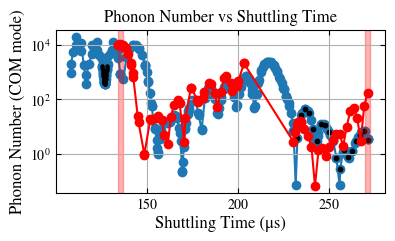

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update(
        {"font.family": "STIXGeneral",
         "xtick.labelsize": 12,
         "xtick.direction": "in",
         "xtick.major.pad": 3,
         "xtick.top": True,
         "ytick.labelsize": 12,
         "ytick.direction": "in",
         "ytick.right": True,
         "axes.labelsize": 12,
         "axes.labelpad": 3,
         "axes.grid": True
    }
)

# Parameters for the simulation
T_factor = (121 / 133.93969396934) * 1.65  # The time factor for the simulation
NUM_VOLTAGE_POINTS = 500  # The points for voltage sampling
T = 150 * 1e-6 * T_factor  # Total time duration in s unit
points = 3000000  # Number of points at which to evaluate the solution

shuttling_time = np.array([2.0, 1.9, 1.8, 1.7, 1.69, 1.68, 1.675, 1.67, 1.66, 1.6, 1.55, 1.5, 1.45, 1.4, 1.35, 1.3, 1.275, 1.2725, 1.2625, 1.25625, 1.25, 1.24375, 1.2375, 1.225, 1.2, 1.175, 1.1725, 1.1625, 1.15, 1.125, 1.1, 1.075, 1.05, 1.025, 1.0]) * 150 * (121 / 133.93969396934)
phonon_number = [3.3162240810623347, 1.1686538823938188, 5.875925464087038, 6.619702650001575, 31.254016433807955, 71.98736367688507, 98.34855030356773, 130.87303629718585, 232.85274899348917, 2391.1302739952052, 147.44020081614985, 629.0087480609346, 268.18965217639294, 48.43543825010925, 206.2857621064642, 95.51753401638237, 36.50945323006546, 28.964561608089042, 7.96054386244553, 1.804352613489891, 0.22117266268485491, 2.8548644300358745, 9.033128088667297, 23.698891504359, 14.689732736191997, 15.435105237356863, 14.186253152704335, 5.481084714468514, 1.6131675500567202, 74.60439276513097, 1871.5136089051891, 7469.869215480245, 9689.46367839787, 3444.424286773976, 822.7717571937637]

shuttling_time_1 = np.array([1.7       , 1.71578947, 1.73157895, 1.74736842, 1.76315789,
                            1.77894737, 1.79473684, 1.81052632, 1.82631579, 1.84210526,
                            1.85789474, 1.87368421, 1.88947368, 1.90526316, 1.92105263,
                            1.93684211, 1.95263158, 1.96842105, 1.98421053, 2.        ]) * 150 * (121 / 133.93969396934)

phonon_number_1 = [6.622719944242334,
                    3.6665789980066514,
                    26.40020560905384,
                    43.26610387296418,
                    32.437882964454495,
                    8.074850695091568,
                    2.982109653755348,
                    11.948611462139123,
                    11.74439618130612,
                    6.192068357055268,
                    3.3273987358235915,
                    0.6739697827116691,
                    0.27495010337452586,
                    1.3850825169641057,
                    0.7593143279522443,
                    1.2361688787016312,
                    2.896015765885327,
                    4.935262779795991,
                    6.860069819101938,
                    3.3229333316504306]

shuttling_time_2 = np.array([1.5       , 1.50842105, 1.51684211, 1.52526316, 1.53368421,
                            1.54210526, 1.55052632, 1.55894737, 1.56736842, 1.57578947,
                            1.58421053, 1.59263158, 1.60105263, 1.60947368, 1.61789474,
                            1.62631579, 1.63473684, 1.64315789, 1.65157895, 1.66      ]) * 150 * (121 / 133.93969396934)

phonon_number_2 = [628.9188948472441,
                    715.8617235495441,
                    625.2224899922396,
                    398.8135916458048,
                    159.31460165015557,
                    49.08760383112478,
                    161.56191075045933,
                    504.30044461484954,
                    1005.1049082936939,
                    1549.1785151046683,
                    2017.1059972761366,
                    2313.9777111072726,
                    2387.4370778102857,
                    2231.2774143359843,
                    1892.4078850788678,
                    1454.499200018254,
                    1014.2565407174377,
                    648.0857324625774,
                    390.34507137128696,
                    232.89951946244153]

shuttling_time_3 = np.linspace(1.1, 1.16, 10) * 150 * (121 / 133.93969396934)
phonon_number_3 = [1871.4529251861752, 992.4690490748741, 451.1546616884751, 171.78240593044322, 55.796053192859674, 18.76592586005597, 8.314730748151963, 3.2465493956254425, 0.9834339791532549, 3.4605420534457125]
[1871.4529251861752, 992.4690490748741, 451.1546616884751, 171.78240593044322, 55.796053192859674, 18.76592586005597, 8.314730748151963, 3.2465493956254425, 0.9834339791532549, 3.4605420534457125]

shuttling_time_4 = np.linspace(1.0, 2.0, 80) * 150 * (121 / 133.93969396934)
phonon_number_4 = [822.8831820325785, 553.1855352141761, 3542.171964861885, 7418.750265052354, 9748.075347736132, 9550.291315380848, 7250.075046199817, 4158.847362108642, 1676.5578137796924, 417.3286389873755, 56.62349334331037, 9.04329312526159, 1.1110347310223108, 7.380877247751045, 15.97618959458514, 13.190498898531047, 16.456690491244057, 26.031210712333166, 20.983015437829177, 5.69234210323791, 0.4792879869919452, 13.311145676331547, 48.19142786474047, 90.1869494360309, 87.08293990635754, 27.439289193761844, 7.943963101493556, 110.59330008038978, 245.44588671044565, 249.18604885410141, 121.19406518440272, 30.174987850247856, 90.65755646185869, 248.02176020203984, 366.8975992970766, 345.02453786359933, 187.05368708804002, 53.45598584149631, 153.89604931299039, 477.0539761262665, 710.1349472245089, 576.5589089972765, 210.53031634995466, 55.093199254533324, 405.46048180363704, 1151.5731883360443, 1922.1306278358686, 2357.619586558614, 2284.2525232653193, 1775.4381028688915, 1105.4180049957135, 562.8893512682979, 259.0906372646809, 124.47093631889408, 55.891271781258354, 13.86489918227468, 0.0674895740823596, 10.593581390571051, 30.409641898581075, 43.07678390368917, 37.392256734106184, 17.760404734702387, 3.106450318201271, 4.344128275799964, 11.791978557101324, 12.772113827422457, 8.299232790727718, 4.895337790600413, 2.853086195149589, 0.7113415941668045, 0.06745745452049429, 1.0813954662514385, 1.2722384550374848, 0.6668664137922837, 1.2210296544611676, 2.5616014949176296, 3.95699332661789, 6.022500602985368, 6.629504719797712, 3.3229333316504306]

shuttling_time_5 = np.array([1.25      , 1.26315789, 1.27631579, 1.28947368, 1.30263158,
                    1.31578947, 1.32894737, 1.34210526, 1.35526316, 1.36842105,
                    1.38157895, 1.39473684, 1.40789474, 1.42105263, 1.43421053,
                    1.44736842, 1.46052632, 1.47368421, 1.48684211, 1.5       ]) * 150 * (121 / 133.93969396934)
phonon_number_5 = [0.21557833883358168,
                    8.889765338956778,
                    40.75899549486657,
                    85.97241022810252,
                    90.36925017194477,
                    30.741205457865956,
                    7.4235807726708,
                    114.52988917197142,
                    251.0120685367646,
                    239.6263609060765,
                    101.36244663037469,
                    29.40305106016917,
                    121.99408817955025,
                    288.4724147117752,
                    377.5509234345375,
                    301.3072286120741,
                    120.33170525893043,
                    59.96463300694118,
                    289.01736659950575,
                    628.9188948472441]

shuttling_time_0 = np.array([1.7       , 1.71578947, 1.73157895, 1.74736842, 1.76315789,
                            1.77894737, 1.79473684, 1.81052632, 1.82631579, 1.84210526,
                            1.85789474, 1.87368421, 1.88947368, 1.90526316, 1.92105263,
                            1.93684211, 1.95263158, 1.96842105, 1.98421053, 2.        ]) * 150 * (121 / 133.93969396934)
phonon_number_0 = [6.611800019088033,
                    3.6582972482942595,
                    26.369318017544657,
                    43.184343173550495,
                    32.4023308321295,
                    8.073363888764545,
                    2.9772072524057354,
                    11.940665437935861,
                    11.725732978507285,
                    6.1844655645330295,
                    3.3125373916212957,
                    0.6704987522671576,
                    0.2719823324680728,
                    1.38020543375336,
                    0.7582715754115237,
                    1.2323576315610096,
                    2.8905536554362423,
                    4.920834741776568,
                    6.82717941312589,
                    3.3061360201165386]

phonon_number_6 = [960.412857263177,
                    5565.232793973766,
                    9689.214239600225,
                    9624.276920402259,
                    5825.74543517543,
                    1763.4641674800007,
                    379.6590828241329,
                    1960.0707266309487,
                    4732.660373963657,
                    6621.267216334895,
                    6431.442126373816,
                    4289.753644587272,
                    1612.4612789634377,
                    376.0004976343955,
                    1649.6030567060948,
                    4488.424703040916,
                    6522.137598909649,
                    6008.294403782537,
                    3384.3072592824346,
                    822.8831820325785]
shuttling_time_6 = np.array([0.8       , 0.81052632, 0.82105263, 0.83157895, 0.84210526,
                            0.85263158, 0.86315789, 0.87368421, 0.88421053, 0.89473684,
                            0.90526316, 0.91578947, 0.92631579, 0.93684211, 0.94736842,
                            0.95789474, 0.96842105, 0.97894737, 0.98947368, 1.        ]) * 150 * (121 / 133.93969396934)

phonon_number_7 = [925.5835720576033,
                540.9867789523305,
                379.5372771205698,
                459.00594628758756,
                776.7624213452759,
                1311.9872709975712,
                2025.5274353012371]
shuttling_time_7 = np.array([0.93, 0.93315789, 0.93631579, 0.93947368, 0.94263158, 0.94578947, 0.94894737]) * 150 * (121 / 133.93969396934)

phonon_number_8 = [540.7838157182764,
                    484.81804175249084,
                    440.35394049977776,
                    407.19763007056184,
                    385.5767372568061,
                    376.54684034588297,
                    379.40067427425936,
                    393.4928146330621,
                    420.26803538991174,
                    459.04890258792]
shuttling_time_8 = np.array([0.93315789, 0.93385964, 0.9345614 , 0.93526315, 0.93596491, 0.93666666, 0.93736842, 0.93807017, 0.93877193, 0.93947368]) * 150 * (121 / 133.93969396934)

phonon_number_9 = [1652.4772295961702,
                    1416.916987380497,
                    1201.199446708044,
                    1006.5449084799493,
                    835.9621789276681,
                    690.6854743866578,
                    572.1272837340895,
                    481.70899237514504,
                    420.50727639426356,
                    389.4163396944165,
                    388.6817234402452,
                    418.93463545608853,
                    479.6264969829406,
                    570.3723559646336,
                    690.9544373690151,
                    839.8290183040909,
                    1016.232803286527,
                    1217.3605466777492,
                    1443.1019558783248,
                    1690.3865706072002]
shuttling_time_9 = np.array([0.92631579, 0.92742382, 0.92853186, 0.92963989, 0.93074792,
                            0.93185596, 0.93296399, 0.93407202, 0.93518006, 0.93628809,
                            0.93739612, 0.93850415, 0.93961219, 0.94072022, 0.94182825,
                            0.94293629, 0.94404432, 0.94515235, 0.94626039, 0.94736842]) * 150 * (121 / 133.93969396934)

phonon_number_10 = [1920.456286688493,
                    19406.050090061202,
                    11549.868445267326,
                    769.5182118228291,
                    9581.306724941125,
                    12788.971323715221,
                    3075.80833112831,
                    3486.6881439897925,
                    13118.459178404775,
                    6465.730063659422]
shuttling_time_10 = np.array([0.8       , 0.82111111, 0.84222222, 0.86333333, 0.88444444,
                            0.90555556, 0.92666667, 0.94777778, 0.96888889, 0.99      ]) * 150 * (121 / 133.93969396934)

phonon_number_11 = [9568.328141283175,
                    8563.478251157201,
                    1786.557164266618,
                    24.143707752822532,
                    0.9226381644066272,
                    17.15466195231177,
                    25.125977877617014,
                    4.99492143709375,
                    22.376485596003374,
                    95.46146530501147,
                    2.5974705857599454,
                    257.4997523929176,
                    80.11713138534785,
                    180.32989742056165,
                    372.23198390284574,
                    52.30088213756731,
                    585.1094444973797,
                    401.2456461285471,
                    295.58568261081183,
                    2081.683960353963]
shuttling_time_11 = np.array([0.99      , 1.01684211, 1.04368421, 1.07052632, 1.09736842,
                            1.12421053, 1.15105263, 1.17789474, 1.20473684, 1.23157895,
                            1.25842105, 1.28526316, 1.31210526, 1.33894737, 1.36578947,
                            1.39263158, 1.41947368, 1.44631579, 1.47315789, 1.5       ]) * 150 * (121 / 133.93969396934)

phonon_number_12 = [2.726979296482458,
                    6.20912002423036,
                    10.86111341545978,
                    14.362937801097196,
                    15.40970522868022,
                    14.086232480250871]
shuttling_time_12 = np.array([1.7       , 1.70612245, 1.7122449 , 1.71836735, 1.7244898 , 1.73061224]) * 150 * (121 / 133.93969396934)

phonon_number_13 = [9567.73064611388,
                    10735.330424443164,
                    9832.64787629046,
                    7423.384802129073,
                    4507.598029273467,
                    2082.1323897876505,
                    659.918578995693]
shuttling_time_13 = np.array([0.99      , 1.00040816, 1.01081633, 1.02122449, 1.03163265, 1.04204082, 1.05244898]) * 150 * (121 / 133.93969396934)

phonon_number_14 = [901.7163254961342,
                    14.277885527396183,
                    0.9363572309346078,
                    18.154305170914057,
                    19.969890977981976,
                    16.9619135738993,
                    2.286897905772318,
                    59.259627176040254,
                    74.33825567929853,
                    20.504558432119925,
                    266.7064531471633,
                    97.0870707143194,
                    115.55097127559138,
                    385.08659426655197,
                    169.21136800818573,
                    181.01348086765677,
                    738.1633370739263,
                    197.28639927428566,
                    453.17792272569903,
                    2081.6519058654426]
shuttling_time_14 = np.array([1.05      , 1.07368421, 1.09736842, 1.12105263, 1.14473684,
                            1.16842105, 1.19210526, 1.21578947, 1.23947368, 1.26315789,
                            1.28684211, 1.31052632, 1.33421053, 1.35789474, 1.38157895,
                            1.40526316, 1.42894737, 1.45263158, 1.47631579, 1.5       ]) * 150 * (121 / 133.93969396934)

phonon_number_15 = [14.303644720707341,
                8.123262964216096,
                4.550113912206718,
                1.7715779668291562,
                0.06542574863248608,
                1.3336742424373118,
                1.609921396344434,
                0.8405368670945713,
                1.7265657280517224,
                3.1097152303331055,
                5.163504234090552,
                5.49155396841289,
                1.855050510487784,
                9.442146094503748,
                36.26556079705349,
                48.25401199884358,
                21.046207410563675,
                2.8340693671259762,
                58.14776920559573,
                176.9946765499624]
shuttling_time_15 = np.array([1.73      , 1.74421053, 1.75842105, 1.77263158, 1.78684211,
                        1.80105263, 1.81526316, 1.82947368, 1.84368421, 1.85789474,
                        1.87210526, 1.88631579, 1.90052632, 1.91473684, 1.92894737,
                        1.94315789, 1.95736842, 1.97157895, 1.98578947, 2.        ]) * 150 * (121 / 133.93969396934)

merged_shuttling_time = np.concatenate((shuttling_time, shuttling_time_1, shuttling_time_2, shuttling_time_3, shuttling_time_4, shuttling_time_5, shuttling_time_6, shuttling_time_7, shuttling_time_8, shuttling_time_9, shuttling_time_10))
merged_phonon_number = np.concatenate((phonon_number, phonon_number_1, phonon_number_2, phonon_number_3, phonon_number_4, phonon_number_5, phonon_number_6, phonon_number_7, phonon_number_8, phonon_number_9, phonon_number_10))

# combined = list(zip(merged_shuttling_time, merged_phonon_number))
# sorted_combined = sorted(combined, key=lambda x: x[0])
# merged_shuttling_time, merged_phonon_number = zip(*sorted_combined)

merged_shuttling_time = merged_shuttling_time.tolist()
merged_phonon_number = merged_phonon_number.tolist()

sorted_pairs = sorted(zip(merged_shuttling_time, merged_phonon_number))
merged_shuttling_time_sorted, merged_phonon_number_sorted = zip(*sorted_pairs)

# Plotting settings
half_column_width_inches = 4.25
aspect_ratio = 2  # Desired aspect ratio
plt.figure(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))

plt.plot(merged_shuttling_time_sorted, merged_phonon_number_sorted, marker='o', linestyle='-', color='C0', zorder=0)
plt.scatter(shuttling_time_0, phonon_number_0, c="black", s=10, zorder=1)
plt.scatter(shuttling_time_8, phonon_number_8, c="black", s=5, zorder=1)
plt.scatter(shuttling_time_9, phonon_number_9, c="black", s=5, zorder=1)
# plt.scatter(shuttling_time_10, phonon_number_10, c="red", s=5, zorder=2)
merged_shuttling_time_5 = np.concatenate((shuttling_time_11, shuttling_time_12, shuttling_time_13, shuttling_time_14, shuttling_time_15))
merged_phonon_number_5 = np.concatenate((phonon_number_11, phonon_number_12, phonon_number_13, phonon_number_14, phonon_number_15))
merged_shuttling_time_5 = merged_shuttling_time_5.tolist()
merged_phonon_number_5 = merged_phonon_number_5.tolist()
sorted_pairs_5 = sorted(zip(merged_shuttling_time_5, merged_phonon_number_5))
merged_shuttling_time_sorted_5, merged_phonon_number_sorted_5 = zip(*sorted_pairs_5)
plt.plot(merged_shuttling_time_sorted_5, merged_phonon_number_sorted_5, marker='o', linestyle='-', c="red", zorder=2)
# plt.plot(shuttling_time_1, phonon_number_1, marker='o', linestyle='-', color='C0')

# Highlight the time windows
time = 150 * (121 / 133.93969396934)
start = time * 0.99
stop = time * 1.01
plt.axvspan(start, stop, color='red', alpha=0.3)

time = 150 * (121 / 133.93969396934) * 2
start = time * 0.995
stop = time * 1.005
plt.axvspan(start, stop, color='red', alpha=0.3)

# plt.xlim(100, 150)
# plt.ylim(100, 2000)

plt.xlabel('Shuttling Time (μs)', fontsize=12)
plt.ylabel('Phonon Number (COM mode)', fontsize=12)
plt.title('Phonon Number vs Shuttling Time', fontsize=12)
plt.yscale('log')
plt.grid(True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

pdf_filename = 'Phonon_number_vs_shuttling_time.pdf'
plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')

# plt.legend()
plt.show()

In [ ]:
150 * (121 / 133.93969396934)

135.50874622839365

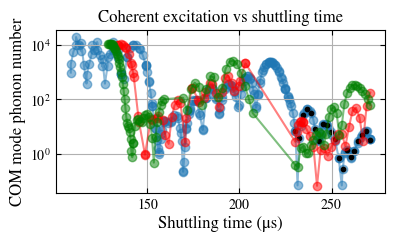

In [18]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update(
        {"font.family": "STIXGeneral",
         "xtick.labelsize": 12,
         "xtick.direction": "in",
         "xtick.major.pad": 3,
         "xtick.top": True,
         "ytick.labelsize": 12,
         "ytick.direction": "in",
         "ytick.right": True,
         "axes.labelsize": 12,
         "axes.labelpad": 3,
         "axes.grid": True
    }
)

# Parameters for the simulation
T_factor = (121 / 133.93969396934) * 1.65  # The time factor for the simulation
NUM_VOLTAGE_POINTS = 500  # The points for voltage sampling
T = 150 * 1e-6 * T_factor  # Total time duration in s unit
points = 3000000  # Number of points at which to evaluate the solution

shuttling_time = np.array([2.0, 1.9, 1.8, 1.7, 1.69, 1.68, 1.675, 1.67, 1.66, 1.6, 1.55, 1.5, 1.45, 1.4, 1.35, 1.3, 1.275, 1.2725, 1.2625, 1.25625, 1.25, 1.24375, 1.2375, 1.225, 1.2, 1.175, 1.1725, 1.1625, 1.15, 1.125, 1.1, 1.075, 1.05, 1.025, 1.0]) * 150 * (121 / 133.93969396934)
phonon_number = [3.3162240810623347, 1.1686538823938188, 5.875925464087038, 6.619702650001575, 31.254016433807955, 71.98736367688507, 98.34855030356773, 130.87303629718585, 232.85274899348917, 2391.1302739952052, 147.44020081614985, 629.0087480609346, 268.18965217639294, 48.43543825010925, 206.2857621064642, 95.51753401638237, 36.50945323006546, 28.964561608089042, 7.96054386244553, 1.804352613489891, 0.22117266268485491, 2.8548644300358745, 9.033128088667297, 23.698891504359, 14.689732736191997, 15.435105237356863, 14.186253152704335, 5.481084714468514, 1.6131675500567202, 74.60439276513097, 1871.5136089051891, 7469.869215480245, 9689.46367839787, 3444.424286773976, 822.7717571937637]

phonon_number_m1 = [10917.831148500894,
                    11204.503136766143,
                    11221.463603616474,
                    10976.710727993826,
                    10497.448718693766,
                    9807.351445832617,
                    8952.06622021338,
                    7974.972236816406,
                    6925.580488995814,
                    5850.266637011716,
                    4798.422598099715,
                    3809.8871368057257,
                    2919.352046646958,
                    2149.1673189952176,
                    1513.7667508605855,
                    1012.5287491080555,
                    638.4661190901367,
                    376.151101137252,
                    204.90507923133984,
                    102.44126052633757,
                    47.743716397042185,
                    22.646531404729735,
                    13.255639171075677,
                    10.228019391596268,
                    8.48703605235511,
                    6.144718720750942,
                    3.3450319915578635,
                    1.2033559675156116,
                    0.7353332177622804,
                    2.394402975256187]
shuttling_time_m1 = np.array([0.95      , 0.95344828, 0.95689655, 0.96034483, 0.9637931 ,
                            0.96724138, 0.97068966, 0.97413793, 0.97758621, 0.98103448,
                            0.98448276, 0.98793103, 0.99137931, 0.99482759, 0.99827586,
                            1.00172414, 1.00517241, 1.00862069, 1.01206897, 1.01551724,
                            1.01896552, 1.02241379, 1.02586207, 1.02931034, 1.03275862,
                            1.0362069 , 1.03965517, 1.04310345, 1.04655172, 1.05      ]) * 150 * (121 / 133.93969396934)

phonon_number_m2 = [0.3823764422417888,
                    0.32502324693579593,
                    1.5604419259381792,
                    1.792498084359018,
                    1.0318683761106808,
                    1.062220981374216,
                    2.0513344908511355,
                    3.1387355842567772,
                    4.653112466975929,
                    6.184761799729591,
                    5.07039360145654,
                    1.9932146360298484,
                    5.471828005631268,
                    22.71604802042077,
                    44.84689894517717,
                    50.27710133536522,
                    30.064086981391384,
                    4.993464381091826,
                    11.364863358670137,
                    68.71847503201228,
                    163.59522658303385,
                    261.3414385227494,
                    328.3085727409664,
                    346.77267259278347,
                    319.2808926109196,
                    264.0782736347852,
                    203.4337857971246,
                    150.28598330503823,
                    104.51495652989107,
                    62.36201898299608]
shuttling_time_m2 = np.array([1.7       , 1.71034483, 1.72068966, 1.73103448, 1.74137931,
                            1.75172414, 1.76206897, 1.77241379, 1.78275862, 1.79310345,
                            1.80344828, 1.8137931 , 1.82413793, 1.83448276, 1.84482759,
                            1.85517241, 1.86551724, 1.87586207, 1.8862069 , 1.89655172,
                            1.90689655, 1.91724138, 1.92758621, 1.93793103, 1.94827586,
                            1.95862069, 1.96896552, 1.97931034, 1.98965517, 2.        ]) * 150 * (121 / 133.93969396934)

phonon_number_m3 = [2.394402975256187,
                    10.341679736630129,
                    17.746883266992494,
                    18.879801967995178,
                    15.84125682167082,
                    15.085175921693596,
                    19.641559461240366,
                    25.98851885910303,
                    27.73577448866504,
                    22.197012471177697,
                    12.312911991024604,
                    3.7304676142863125,
                    0.46682114117097395,
                    3.93242312592925,
                    14.832571322170065,
                    34.3920546457663,
                    61.34957692396912,
                    88.05185399543221,
                    100.43843946007372]
shuttling_time_m3 = np.array([1.05      , 1.05689655, 1.0637931 , 1.07068966, 1.07758621,
                            1.08448276, 1.09137931, 1.09827586, 1.10517241, 1.11206897,
                            1.11896552, 1.12586207, 1.13275862, 1.13965517, 1.14655172,
                            1.15344828, 1.16034483, 1.16724138, 1.17413793]) * 150 * (121 / 133.93969396934)

phonon_number_m4 = [113.95230098887484,
                    39.61614232918734,
                    235.84787876381606,
                    404.5630021950763,
                    291.14823079863373,
                    63.342721596904354,
                    235.35569493472556,
                    704.8600024415663,
                    639.3219657559627,
                    122.5695425036581,
                    261.8359054904077,
                    1332.582851769415,
                    2430.9288206784604,
                    2661.6464524165476,
                    1921.5530191455898,
                    905.0772717623831,
                    300.0969284581349,
                    104.25273864724238,
                    31.09823070724036]
shuttling_time_m4 = np.array([1.25      , 1.26551724, 1.28103448, 1.29655172, 1.31206897,
                            1.32758621, 1.34310345, 1.35862069, 1.37413793, 1.38965517,
                            1.40517241, 1.42068966, 1.4362069 , 1.45172414, 1.46724138,
                            1.48275862, 1.49827586, 1.5137931 , 1.52931034])  * 150 * (121 / 133.93969396934)

shuttling_time_1 = np.array([1.7       , 1.71578947, 1.73157895, 1.74736842, 1.76315789,
                            1.77894737, 1.79473684, 1.81052632, 1.82631579, 1.84210526,
                            1.85789474, 1.87368421, 1.88947368, 1.90526316, 1.92105263,
                            1.93684211, 1.95263158, 1.96842105, 1.98421053, 2.        ]) * 150 * (121 / 133.93969396934)

phonon_number_1 = [6.622719944242334,
                    3.6665789980066514,
                    26.40020560905384,
                    43.26610387296418,
                    32.437882964454495,
                    8.074850695091568,
                    2.982109653755348,
                    11.948611462139123,
                    11.74439618130612,
                    6.192068357055268,
                    3.3273987358235915,
                    0.6739697827116691,
                    0.27495010337452586,
                    1.3850825169641057,
                    0.7593143279522443,
                    1.2361688787016312,
                    2.896015765885327,
                    4.935262779795991,
                    6.860069819101938,
                    3.3229333316504306]

shuttling_time_2 = np.array([1.5       , 1.50842105, 1.51684211, 1.52526316, 1.53368421,
                            1.54210526, 1.55052632, 1.55894737, 1.56736842, 1.57578947,
                            1.58421053, 1.59263158, 1.60105263, 1.60947368, 1.61789474,
                            1.62631579, 1.63473684, 1.64315789, 1.65157895, 1.66      ]) * 150 * (121 / 133.93969396934)

phonon_number_2 = [628.9188948472441,
                    715.8617235495441,
                    625.2224899922396,
                    398.8135916458048,
                    159.31460165015557,
                    49.08760383112478,
                    161.56191075045933,
                    504.30044461484954,
                    1005.1049082936939,
                    1549.1785151046683,
                    2017.1059972761366,
                    2313.9777111072726,
                    2387.4370778102857,
                    2231.2774143359843,
                    1892.4078850788678,
                    1454.499200018254,
                    1014.2565407174377,
                    648.0857324625774,
                    390.34507137128696,
                    232.89951946244153]

shuttling_time_3 = np.linspace(1.1, 1.16, 10) * 150 * (121 / 133.93969396934)
phonon_number_3 = [1871.4529251861752, 992.4690490748741, 451.1546616884751, 171.78240593044322, 55.796053192859674, 18.76592586005597, 8.314730748151963, 3.2465493956254425, 0.9834339791532549, 3.4605420534457125]
[1871.4529251861752, 992.4690490748741, 451.1546616884751, 171.78240593044322, 55.796053192859674, 18.76592586005597, 8.314730748151963, 3.2465493956254425, 0.9834339791532549, 3.4605420534457125]

shuttling_time_4 = np.linspace(1.0, 2.0, 80) * 150 * (121 / 133.93969396934)
phonon_number_4 = [822.8831820325785, 553.1855352141761, 3542.171964861885, 7418.750265052354, 9748.075347736132, 9550.291315380848, 7250.075046199817, 4158.847362108642, 1676.5578137796924, 417.3286389873755, 56.62349334331037, 9.04329312526159, 1.1110347310223108, 7.380877247751045, 15.97618959458514, 13.190498898531047, 16.456690491244057, 26.031210712333166, 20.983015437829177, 5.69234210323791, 0.4792879869919452, 13.311145676331547, 48.19142786474047, 90.1869494360309, 87.08293990635754, 27.439289193761844, 7.943963101493556, 110.59330008038978, 245.44588671044565, 249.18604885410141, 121.19406518440272, 30.174987850247856, 90.65755646185869, 248.02176020203984, 366.8975992970766, 345.02453786359933, 187.05368708804002, 53.45598584149631, 153.89604931299039, 477.0539761262665, 710.1349472245089, 576.5589089972765, 210.53031634995466, 55.093199254533324, 405.46048180363704, 1151.5731883360443, 1922.1306278358686, 2357.619586558614, 2284.2525232653193, 1775.4381028688915, 1105.4180049957135, 562.8893512682979, 259.0906372646809, 124.47093631889408, 55.891271781258354, 13.86489918227468, 0.0674895740823596, 10.593581390571051, 30.409641898581075, 43.07678390368917, 37.392256734106184, 17.760404734702387, 3.106450318201271, 4.344128275799964, 11.791978557101324, 12.772113827422457, 8.299232790727718, 4.895337790600413, 2.853086195149589, 0.7113415941668045, 0.06745745452049429, 1.0813954662514385, 1.2722384550374848, 0.6668664137922837, 1.2210296544611676, 2.5616014949176296, 3.95699332661789, 6.022500602985368, 6.629504719797712, 3.3229333316504306]

shuttling_time_5 = np.array([1.25      , 1.26315789, 1.27631579, 1.28947368, 1.30263158,
                    1.31578947, 1.32894737, 1.34210526, 1.35526316, 1.36842105,
                    1.38157895, 1.39473684, 1.40789474, 1.42105263, 1.43421053,
                    1.44736842, 1.46052632, 1.47368421, 1.48684211, 1.5       ]) * 150 * (121 / 133.93969396934)
phonon_number_5 = [0.21557833883358168,
                    8.889765338956778,
                    40.75899549486657,
                    85.97241022810252,
                    90.36925017194477,
                    30.741205457865956,
                    7.4235807726708,
                    114.52988917197142,
                    251.0120685367646,
                    239.6263609060765,
                    101.36244663037469,
                    29.40305106016917,
                    121.99408817955025,
                    288.4724147117752,
                    377.5509234345375,
                    301.3072286120741,
                    120.33170525893043,
                    59.96463300694118,
                    289.01736659950575,
                    628.9188948472441]

shuttling_time_0 = np.array([1.7       , 1.71578947, 1.73157895, 1.74736842, 1.76315789,
                            1.77894737, 1.79473684, 1.81052632, 1.82631579, 1.84210526,
                            1.85789474, 1.87368421, 1.88947368, 1.90526316, 1.92105263,
                            1.93684211, 1.95263158, 1.96842105, 1.98421053, 2.        ]) * 150 * (121 / 133.93969396934)
phonon_number_0 = [6.611800019088033,
                    3.6582972482942595,
                    26.369318017544657,
                    43.184343173550495,
                    32.4023308321295,
                    8.073363888764545,
                    2.9772072524057354,
                    11.940665437935861,
                    11.725732978507285,
                    6.1844655645330295,
                    3.3125373916212957,
                    0.6704987522671576,
                    0.2719823324680728,
                    1.38020543375336,
                    0.7582715754115237,
                    1.2323576315610096,
                    2.8905536554362423,
                    4.920834741776568,
                    6.82717941312589,
                    3.3061360201165386]

phonon_number_6 = [960.412857263177,
                    5565.232793973766,
                    9689.214239600225,
                    9624.276920402259,
                    5825.74543517543,
                    1763.4641674800007,
                    379.6590828241329,
                    1960.0707266309487,
                    4732.660373963657,
                    6621.267216334895,
                    6431.442126373816,
                    4289.753644587272,
                    1612.4612789634377,
                    376.0004976343955,
                    1649.6030567060948,
                    4488.424703040916,
                    6522.137598909649,
                    6008.294403782537,
                    3384.3072592824346,
                    822.8831820325785]
shuttling_time_6 = np.array([0.8       , 0.81052632, 0.82105263, 0.83157895, 0.84210526,
                            0.85263158, 0.86315789, 0.87368421, 0.88421053, 0.89473684,
                            0.90526316, 0.91578947, 0.92631579, 0.93684211, 0.94736842,
                            0.95789474, 0.96842105, 0.97894737, 0.98947368, 1.        ]) * 150 * (121 / 133.93969396934)

phonon_number_7 = [925.5835720576033,
                540.9867789523305,
                379.5372771205698,
                459.00594628758756,
                776.7624213452759,
                1311.9872709975712,
                2025.5274353012371]
shuttling_time_7 = np.array([0.93, 0.93315789, 0.93631579, 0.93947368, 0.94263158, 0.94578947, 0.94894737]) * 150 * (121 / 133.93969396934)

phonon_number_8 = [540.7838157182764,
                    484.81804175249084,
                    440.35394049977776,
                    407.19763007056184,
                    385.5767372568061,
                    376.54684034588297,
                    379.40067427425936,
                    393.4928146330621,
                    420.26803538991174,
                    459.04890258792]
shuttling_time_8 = np.array([0.93315789, 0.93385964, 0.9345614 , 0.93526315, 0.93596491, 0.93666666, 0.93736842, 0.93807017, 0.93877193, 0.93947368]) * 150 * (121 / 133.93969396934)

phonon_number_9 = [1652.4772295961702,
                    1416.916987380497,
                    1201.199446708044,
                    1006.5449084799493,
                    835.9621789276681,
                    690.6854743866578,
                    572.1272837340895,
                    481.70899237514504,
                    420.50727639426356,
                    389.4163396944165,
                    388.6817234402452,
                    418.93463545608853,
                    479.6264969829406,
                    570.3723559646336,
                    690.9544373690151,
                    839.8290183040909,
                    1016.232803286527,
                    1217.3605466777492,
                    1443.1019558783248,
                    1690.3865706072002]
shuttling_time_9 = np.array([0.92631579, 0.92742382, 0.92853186, 0.92963989, 0.93074792,
                            0.93185596, 0.93296399, 0.93407202, 0.93518006, 0.93628809,
                            0.93739612, 0.93850415, 0.93961219, 0.94072022, 0.94182825,
                            0.94293629, 0.94404432, 0.94515235, 0.94626039, 0.94736842]) * 150 * (121 / 133.93969396934)

phonon_number_10 = [1920.456286688493,
                    19406.050090061202,
                    11549.868445267326,
                    769.5182118228291,
                    9581.306724941125,
                    12788.971323715221,
                    3075.80833112831,
                    3486.6881439897925,
                    13118.459178404775,
                    6465.730063659422]
shuttling_time_10 = np.array([0.8       , 0.82111111, 0.84222222, 0.86333333, 0.88444444,
                            0.90555556, 0.92666667, 0.94777778, 0.96888889, 0.99      ]) * 150 * (121 / 133.93969396934)

phonon_number_11 = [9568.328141283175,
                    8563.478251157201,
                    1786.557164266618,
                    24.143707752822532,
                    0.9226381644066272,
                    17.15466195231177,
                    25.125977877617014,
                    4.99492143709375,
                    22.376485596003374,
                    95.46146530501147,
                    2.5974705857599454,
                    257.4997523929176,
                    80.11713138534785,
                    180.32989742056165,
                    372.23198390284574,
                    52.30088213756731,
                    585.1094444973797,
                    401.2456461285471,
                    295.58568261081183,
                    2081.683960353963]
shuttling_time_11 = np.array([0.99      , 1.01684211, 1.04368421, 1.07052632, 1.09736842,
                            1.12421053, 1.15105263, 1.17789474, 1.20473684, 1.23157895,
                            1.25842105, 1.28526316, 1.31210526, 1.33894737, 1.36578947,
                            1.39263158, 1.41947368, 1.44631579, 1.47315789, 1.5       ]) * 150 * (121 / 133.93969396934)

phonon_number_12 = [2.726979296482458,
                    6.20912002423036,
                    10.86111341545978,
                    14.362937801097196,
                    15.40970522868022,
                    14.086232480250871]
shuttling_time_12 = np.array([1.7       , 1.70612245, 1.7122449 , 1.71836735, 1.7244898 , 1.73061224]) * 150 * (121 / 133.93969396934)

phonon_number_13 = [9567.73064611388,
                    10735.330424443164,
                    9832.64787629046,
                    7423.384802129073,
                    4507.598029273467,
                    2082.1323897876505,
                    659.918578995693]
shuttling_time_13 = np.array([0.99      , 1.00040816, 1.01081633, 1.02122449, 1.03163265, 1.04204082, 1.05244898]) * 150 * (121 / 133.93969396934)

phonon_number_14 = [901.7163254961342,
                    14.277885527396183,
                    0.9363572309346078,
                    18.154305170914057,
                    19.969890977981976,
                    16.9619135738993,
                    2.286897905772318,
                    59.259627176040254,
                    74.33825567929853,
                    20.504558432119925,
                    266.7064531471633,
                    97.0870707143194,
                    115.55097127559138,
                    385.08659426655197,
                    169.21136800818573,
                    181.01348086765677,
                    738.1633370739263,
                    197.28639927428566,
                    453.17792272569903,
                    2081.6519058654426]
shuttling_time_14 = np.array([1.05      , 1.07368421, 1.09736842, 1.12105263, 1.14473684,
                            1.16842105, 1.19210526, 1.21578947, 1.23947368, 1.26315789,
                            1.28684211, 1.31052632, 1.33421053, 1.35789474, 1.38157895,
                            1.40526316, 1.42894737, 1.45263158, 1.47631579, 1.5       ]) * 150 * (121 / 133.93969396934)

phonon_number_15 = [14.303644720707341,
                8.123262964216096,
                4.550113912206718,
                1.7715779668291562,
                0.06542574863248608,
                1.3336742424373118,
                1.609921396344434,
                0.8405368670945713,
                1.7265657280517224,
                3.1097152303331055,
                5.163504234090552,
                5.49155396841289,
                1.855050510487784,
                9.442146094503748,
                36.26556079705349,
                48.25401199884358,
                21.046207410563675,
                2.8340693671259762,
                58.14776920559573,
                176.9946765499624]
shuttling_time_15 = np.array([1.73      , 1.74421053, 1.75842105, 1.77263158, 1.78684211,
                        1.80105263, 1.81526316, 1.82947368, 1.84368421, 1.85789474,
                        1.87210526, 1.88631579, 1.90052632, 1.91473684, 1.92894737,
                        1.94315789, 1.95736842, 1.97157895, 1.98578947, 2.        ]) * 150 * (121 / 133.93969396934)

merged_shuttling_time = np.concatenate((shuttling_time, shuttling_time_1, shuttling_time_2, shuttling_time_3, shuttling_time_4, shuttling_time_5, shuttling_time_6, shuttling_time_10))
merged_phonon_number = np.concatenate((phonon_number, phonon_number_1, phonon_number_2, phonon_number_3, phonon_number_4, phonon_number_5, phonon_number_6, phonon_number_10))

# combined = list(zip(merged_shuttling_time, merged_phonon_number))
# sorted_combined = sorted(combined, key=lambda x: x[0])
# merged_shuttling_time, merged_phonon_number = zip(*sorted_combined)

merged_shuttling_time = merged_shuttling_time.tolist()
merged_phonon_number = merged_phonon_number.tolist()

sorted_pairs = sorted(zip(merged_shuttling_time, merged_phonon_number))
merged_shuttling_time_sorted, merged_phonon_number_sorted = zip(*sorted_pairs)

# Plotting settings
half_column_width_inches = 4.25
aspect_ratio = 2  # Desired aspect ratio
plt.figure(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))

plt.plot(merged_shuttling_time_sorted, merged_phonon_number_sorted, marker='o', linestyle='-', color='C0', zorder=0, alpha=0.5)
plt.scatter(shuttling_time_0, phonon_number_0, c="black", s=10, zorder=1)
# plt.scatter(shuttling_time_8, phonon_number_8, c="black", s=5, zorder=1)
# plt.scatter(shuttling_time_9, phonon_number_9, c="black", s=5, zorder=1)
# plt.scatter(shuttling_time_10, phonon_number_10, c="red", s=5, zorder=2)
merged_shuttling_time_5 = np.concatenate((shuttling_time_11, shuttling_time_12, shuttling_time_13, shuttling_time_14, shuttling_time_15))
merged_phonon_number_5 = np.concatenate((phonon_number_11, phonon_number_12, phonon_number_13, phonon_number_14, phonon_number_15))
merged_shuttling_time_5 = merged_shuttling_time_5.tolist()
merged_phonon_number_5 = merged_phonon_number_5.tolist()
sorted_pairs_5 = sorted(zip(merged_shuttling_time_5, merged_phonon_number_5))
merged_shuttling_time_sorted_5, merged_phonon_number_sorted_5 = zip(*sorted_pairs_5)
plt.plot(merged_shuttling_time_sorted_5, merged_phonon_number_sorted_5, marker='o', linestyle='-', c="red", zorder=2, alpha=0.5)
# plt.plot(shuttling_time_1, phonon_number_1, marker='o', linestyle='-', color='C0')

merged_shuttling_time_10 = np.concatenate((shuttling_time_m1, shuttling_time_m2, shuttling_time_m3, shuttling_time_m4))
merged_phonon_number_10 = np.concatenate((phonon_number_m1, phonon_number_m2, phonon_number_m3, phonon_number_m4))
merged_shuttling_time_10 = merged_shuttling_time_10.tolist()
merged_phonon_number_10 = merged_phonon_number_10.tolist()
sorted_pairs_10 = sorted(zip(merged_shuttling_time_10, merged_phonon_number_10))
merged_shuttling_time_sorted_10, merged_phonon_number_sorted_10 = zip(*sorted_pairs_10)
plt.plot(merged_shuttling_time_sorted_10, merged_phonon_number_sorted_10, marker='o', linestyle='-', c="green", zorder=2, alpha=0.5)

# plt.xlim(100, 150)
# plt.ylim(100, 2000)

plt.xlabel('Shuttling time (μs)', fontsize=12)
plt.ylabel('COM mode phonon number', fontsize=12)
plt.title('Coherent excitation vs shuttling time', fontsize=12)
plt.yscale('log')
plt.grid(True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

pdf_filename = 'Phonon_number_vs_shuttling_time.pdf'
plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')

# plt.legend()
plt.show()

<>:454: SyntaxWarning: invalid escape sequence '\o'
<>:472: SyntaxWarning: invalid escape sequence '\o'
<>:488: SyntaxWarning: invalid escape sequence '\o'
<>:454: SyntaxWarning: invalid escape sequence '\o'
<>:472: SyntaxWarning: invalid escape sequence '\o'
<>:488: SyntaxWarning: invalid escape sequence '\o'
/var/folders/s8/dpnknm2j0kj9ww1r_nvtxdrr0000gq/T/ipykernel_32071/3290057845.py:454: SyntaxWarning: invalid escape sequence '\o'
  plt.plot(merged_shuttling_time_sorted, merged_phonon_number_sorted, marker='o', linestyle='-', color='C0', zorder=0, alpha=0.5, label='$\omega_{\mathrm{COM}} = \omega_{\mathrm{0}}$')
/var/folders/s8/dpnknm2j0kj9ww1r_nvtxdrr0000gq/T/ipykernel_32071/3290057845.py:472: SyntaxWarning: invalid escape sequence '\o'
  plt.plot(merged_shuttling_time_sorted_5_1, merged_phonon_number_sorted_5_1, marker='^', linestyle='-', c="red", zorder=2, alpha=0.6, label='$\omega_{\mathrm{COM}} = 1.05 \, \omega_{\mathrm{0}}$')
/var/folders/s8/dpnknm2j0kj9ww1r_nvtxdrr0000gq/T/

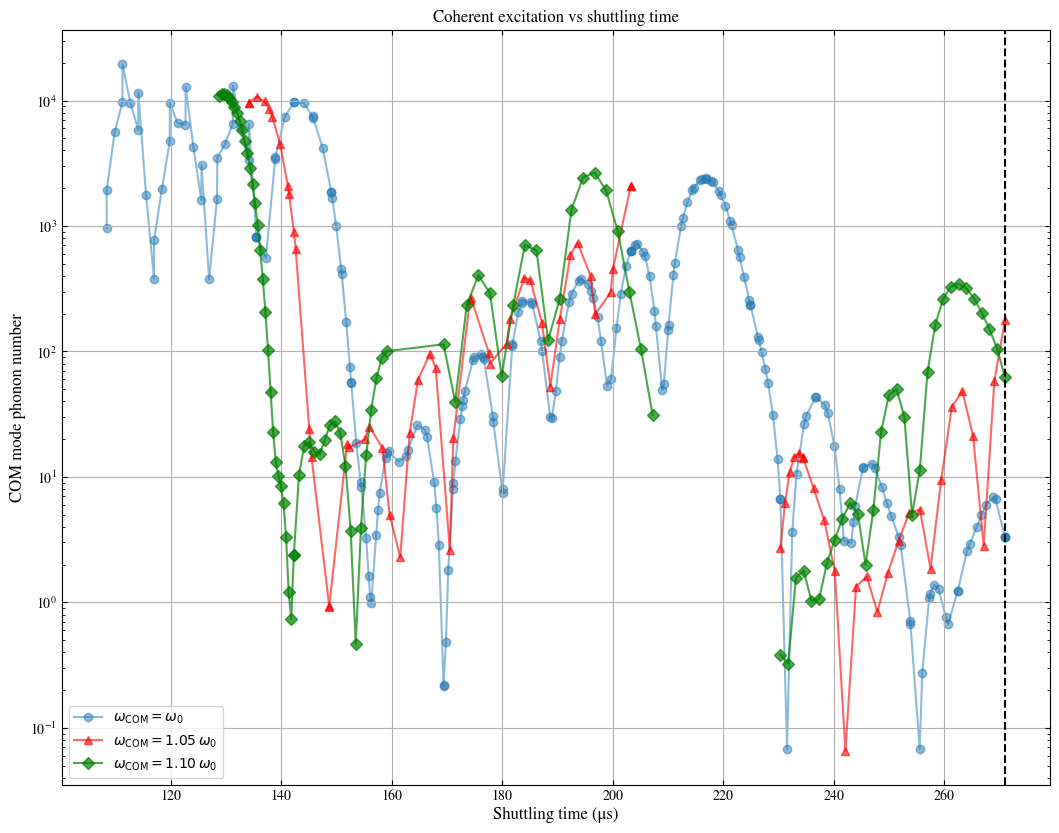

In [6]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update(
        {"font.family": "STIXGeneral",
         "xtick.labelsize": 12,
         "xtick.direction": "in",
         "xtick.major.pad": 3,
         "xtick.top": True,
         "ytick.labelsize": 12,
         "ytick.direction": "in",
         "ytick.right": True,
         "axes.labelsize": 12,
         "axes.labelpad": 3,
         "axes.grid": True
    }
)

# Parameters for the simulation
T_factor = (121 / 133.93969396934) * 1.65  # The time factor for the simulation
NUM_VOLTAGE_POINTS = 500  # The points for voltage sampling
T = 150 * 1e-6 * T_factor  # Total time duration in s unit
points = 3000000  # Number of points at which to evaluate the solution

shuttling_time = np.array([2.0, 1.9, 1.8, 1.7, 1.69, 1.68, 1.675, 1.67, 1.66, 1.6, 1.55, 1.5, 1.45, 1.4, 1.35, 1.3, 1.275, 1.2725, 1.2625, 1.25625, 1.25, 1.24375, 1.2375, 1.225, 1.2, 1.175, 1.1725, 1.1625, 1.15, 1.125, 1.1, 1.075, 1.05, 1.025, 1.0]) * 150 * (121 / 133.93969396934)
phonon_number = [3.3162240810623347, 1.1686538823938188, 5.875925464087038, 6.619702650001575, 31.254016433807955, 71.98736367688507, 98.34855030356773, 130.87303629718585, 232.85274899348917, 2391.1302739952052, 147.44020081614985, 629.0087480609346, 268.18965217639294, 48.43543825010925, 206.2857621064642, 95.51753401638237, 36.50945323006546, 28.964561608089042, 7.96054386244553, 1.804352613489891, 0.22117266268485491, 2.8548644300358745, 9.033128088667297, 23.698891504359, 14.689732736191997, 15.435105237356863, 14.186253152704335, 5.481084714468514, 1.6131675500567202, 74.60439276513097, 1871.5136089051891, 7469.869215480245, 9689.46367839787, 3444.424286773976, 822.7717571937637]

phonon_number_m1 = [10917.831148500894,
                    11204.503136766143,
                    11221.463603616474,
                    10976.710727993826,
                    10497.448718693766,
                    9807.351445832617,
                    8952.06622021338,
                    7974.972236816406,
                    6925.580488995814,
                    5850.266637011716,
                    4798.422598099715,
                    3809.8871368057257,
                    2919.352046646958,
                    2149.1673189952176,
                    1513.7667508605855,
                    1012.5287491080555,
                    638.4661190901367,
                    376.151101137252,
                    204.90507923133984,
                    102.44126052633757,
                    47.743716397042185,
                    22.646531404729735,
                    13.255639171075677,
                    10.228019391596268,
                    8.48703605235511,
                    6.144718720750942,
                    3.3450319915578635,
                    1.2033559675156116,
                    0.7353332177622804,
                    2.394402975256187]
shuttling_time_m1 = np.array([0.95      , 0.95344828, 0.95689655, 0.96034483, 0.9637931 ,
                            0.96724138, 0.97068966, 0.97413793, 0.97758621, 0.98103448,
                            0.98448276, 0.98793103, 0.99137931, 0.99482759, 0.99827586,
                            1.00172414, 1.00517241, 1.00862069, 1.01206897, 1.01551724,
                            1.01896552, 1.02241379, 1.02586207, 1.02931034, 1.03275862,
                            1.0362069 , 1.03965517, 1.04310345, 1.04655172, 1.05      ]) * 150 * (121 / 133.93969396934)

phonon_number_m2 = [0.3823764422417888,
                    0.32502324693579593,
                    1.5604419259381792,
                    1.792498084359018,
                    1.0318683761106808,
                    1.062220981374216,
                    2.0513344908511355,
                    3.1387355842567772,
                    4.653112466975929,
                    6.184761799729591,
                    5.07039360145654,
                    1.9932146360298484,
                    5.471828005631268,
                    22.71604802042077,
                    44.84689894517717,
                    50.27710133536522,
                    30.064086981391384,
                    4.993464381091826,
                    11.364863358670137,
                    68.71847503201228,
                    163.59522658303385,
                    261.3414385227494,
                    328.3085727409664,
                    346.77267259278347,
                    319.2808926109196,
                    264.0782736347852,
                    203.4337857971246,
                    150.28598330503823,
                    104.51495652989107,
                    62.36201898299608]
shuttling_time_m2 = np.array([1.7       , 1.71034483, 1.72068966, 1.73103448, 1.74137931,
                            1.75172414, 1.76206897, 1.77241379, 1.78275862, 1.79310345,
                            1.80344828, 1.8137931 , 1.82413793, 1.83448276, 1.84482759,
                            1.85517241, 1.86551724, 1.87586207, 1.8862069 , 1.89655172,
                            1.90689655, 1.91724138, 1.92758621, 1.93793103, 1.94827586,
                            1.95862069, 1.96896552, 1.97931034, 1.98965517, 2.        ]) * 150 * (121 / 133.93969396934)

phonon_number_m3 = [2.394402975256187,
                    10.341679736630129,
                    17.746883266992494,
                    18.879801967995178,
                    15.84125682167082,
                    15.085175921693596,
                    19.641559461240366,
                    25.98851885910303,
                    27.73577448866504,
                    22.197012471177697,
                    12.312911991024604,
                    3.7304676142863125,
                    0.46682114117097395,
                    3.93242312592925,
                    14.832571322170065,
                    34.3920546457663,
                    61.34957692396912,
                    88.05185399543221,
                    100.43843946007372]
shuttling_time_m3 = np.array([1.05      , 1.05689655, 1.0637931 , 1.07068966, 1.07758621,
                            1.08448276, 1.09137931, 1.09827586, 1.10517241, 1.11206897,
                            1.11896552, 1.12586207, 1.13275862, 1.13965517, 1.14655172,
                            1.15344828, 1.16034483, 1.16724138, 1.17413793]) * 150 * (121 / 133.93969396934)

phonon_number_m4 = [113.95230098887484,
                    39.61614232918734,
                    235.84787876381606,
                    404.5630021950763,
                    291.14823079863373,
                    63.342721596904354,
                    235.35569493472556,
                    704.8600024415663,
                    639.3219657559627,
                    122.5695425036581,
                    261.8359054904077,
                    1332.582851769415,
                    2430.9288206784604,
                    2661.6464524165476,
                    1921.5530191455898,
                    905.0772717623831,
                    300.0969284581349,
                    104.25273864724238,
                    31.09823070724036]
shuttling_time_m4 = np.array([1.25      , 1.26551724, 1.28103448, 1.29655172, 1.31206897,
                            1.32758621, 1.34310345, 1.35862069, 1.37413793, 1.38965517,
                            1.40517241, 1.42068966, 1.4362069 , 1.45172414, 1.46724138,
                            1.48275862, 1.49827586, 1.5137931 , 1.52931034])  * 150 * (121 / 133.93969396934)

shuttling_time_1 = np.array([1.7       , 1.71578947, 1.73157895, 1.74736842, 1.76315789,
                            1.77894737, 1.79473684, 1.81052632, 1.82631579, 1.84210526,
                            1.85789474, 1.87368421, 1.88947368, 1.90526316, 1.92105263,
                            1.93684211, 1.95263158, 1.96842105, 1.98421053, 2.        ]) * 150 * (121 / 133.93969396934)

phonon_number_1 = [6.622719944242334,
                    3.6665789980066514,
                    26.40020560905384,
                    43.26610387296418,
                    32.437882964454495,
                    8.074850695091568,
                    2.982109653755348,
                    11.948611462139123,
                    11.74439618130612,
                    6.192068357055268,
                    3.3273987358235915,
                    0.6739697827116691,
                    0.27495010337452586,
                    1.3850825169641057,
                    0.7593143279522443,
                    1.2361688787016312,
                    2.896015765885327,
                    4.935262779795991,
                    6.860069819101938,
                    3.3229333316504306]

shuttling_time_2 = np.array([1.5       , 1.50842105, 1.51684211, 1.52526316, 1.53368421,
                            1.54210526, 1.55052632, 1.55894737, 1.56736842, 1.57578947,
                            1.58421053, 1.59263158, 1.60105263, 1.60947368, 1.61789474,
                            1.62631579, 1.63473684, 1.64315789, 1.65157895, 1.66      ]) * 150 * (121 / 133.93969396934)

phonon_number_2 = [628.9188948472441,
                    715.8617235495441,
                    625.2224899922396,
                    398.8135916458048,
                    159.31460165015557,
                    49.08760383112478,
                    161.56191075045933,
                    504.30044461484954,
                    1005.1049082936939,
                    1549.1785151046683,
                    2017.1059972761366,
                    2313.9777111072726,
                    2387.4370778102857,
                    2231.2774143359843,
                    1892.4078850788678,
                    1454.499200018254,
                    1014.2565407174377,
                    648.0857324625774,
                    390.34507137128696,
                    232.89951946244153]

shuttling_time_3 = np.linspace(1.1, 1.16, 10) * 150 * (121 / 133.93969396934)
phonon_number_3 = [1871.4529251861752, 992.4690490748741, 451.1546616884751, 171.78240593044322, 55.796053192859674, 18.76592586005597, 8.314730748151963, 3.2465493956254425, 0.9834339791532549, 3.4605420534457125]
[1871.4529251861752, 992.4690490748741, 451.1546616884751, 171.78240593044322, 55.796053192859674, 18.76592586005597, 8.314730748151963, 3.2465493956254425, 0.9834339791532549, 3.4605420534457125]

shuttling_time_4 = np.linspace(1.0, 2.0, 80) * 150 * (121 / 133.93969396934)
phonon_number_4 = [822.8831820325785, 553.1855352141761, 3542.171964861885, 7418.750265052354, 9748.075347736132, 9550.291315380848, 7250.075046199817, 4158.847362108642, 1676.5578137796924, 417.3286389873755, 56.62349334331037, 9.04329312526159, 1.1110347310223108, 7.380877247751045, 15.97618959458514, 13.190498898531047, 16.456690491244057, 26.031210712333166, 20.983015437829177, 5.69234210323791, 0.4792879869919452, 13.311145676331547, 48.19142786474047, 90.1869494360309, 87.08293990635754, 27.439289193761844, 7.943963101493556, 110.59330008038978, 245.44588671044565, 249.18604885410141, 121.19406518440272, 30.174987850247856, 90.65755646185869, 248.02176020203984, 366.8975992970766, 345.02453786359933, 187.05368708804002, 53.45598584149631, 153.89604931299039, 477.0539761262665, 710.1349472245089, 576.5589089972765, 210.53031634995466, 55.093199254533324, 405.46048180363704, 1151.5731883360443, 1922.1306278358686, 2357.619586558614, 2284.2525232653193, 1775.4381028688915, 1105.4180049957135, 562.8893512682979, 259.0906372646809, 124.47093631889408, 55.891271781258354, 13.86489918227468, 0.0674895740823596, 10.593581390571051, 30.409641898581075, 43.07678390368917, 37.392256734106184, 17.760404734702387, 3.106450318201271, 4.344128275799964, 11.791978557101324, 12.772113827422457, 8.299232790727718, 4.895337790600413, 2.853086195149589, 0.7113415941668045, 0.06745745452049429, 1.0813954662514385, 1.2722384550374848, 0.6668664137922837, 1.2210296544611676, 2.5616014949176296, 3.95699332661789, 6.022500602985368, 6.629504719797712, 3.3229333316504306]

shuttling_time_5 = np.array([1.25      , 1.26315789, 1.27631579, 1.28947368, 1.30263158,
                    1.31578947, 1.32894737, 1.34210526, 1.35526316, 1.36842105,
                    1.38157895, 1.39473684, 1.40789474, 1.42105263, 1.43421053,
                    1.44736842, 1.46052632, 1.47368421, 1.48684211, 1.5       ]) * 150 * (121 / 133.93969396934)
phonon_number_5 = [0.21557833883358168,
                    8.889765338956778,
                    40.75899549486657,
                    85.97241022810252,
                    90.36925017194477,
                    30.741205457865956,
                    7.4235807726708,
                    114.52988917197142,
                    251.0120685367646,
                    239.6263609060765,
                    101.36244663037469,
                    29.40305106016917,
                    121.99408817955025,
                    288.4724147117752,
                    377.5509234345375,
                    301.3072286120741,
                    120.33170525893043,
                    59.96463300694118,
                    289.01736659950575,
                    628.9188948472441]

shuttling_time_0 = np.array([1.7       , 1.71578947, 1.73157895, 1.74736842, 1.76315789,
                            1.77894737, 1.79473684, 1.81052632, 1.82631579, 1.84210526,
                            1.85789474, 1.87368421, 1.88947368, 1.90526316, 1.92105263,
                            1.93684211, 1.95263158, 1.96842105, 1.98421053, 2.        ]) * 150 * (121 / 133.93969396934)
phonon_number_0 = [6.611800019088033,
                    3.6582972482942595,
                    26.369318017544657,
                    43.184343173550495,
                    32.4023308321295,
                    8.073363888764545,
                    2.9772072524057354,
                    11.940665437935861,
                    11.725732978507285,
                    6.1844655645330295,
                    3.3125373916212957,
                    0.6704987522671576,
                    0.2719823324680728,
                    1.38020543375336,
                    0.7582715754115237,
                    1.2323576315610096,
                    2.8905536554362423,
                    4.920834741776568,
                    6.82717941312589,
                    3.3061360201165386]

phonon_number_6 = [960.412857263177,
                    5565.232793973766,
                    9689.214239600225,
                    9624.276920402259,
                    5825.74543517543,
                    1763.4641674800007,
                    379.6590828241329,
                    1960.0707266309487,
                    4732.660373963657,
                    6621.267216334895,
                    6431.442126373816,
                    4289.753644587272,
                    1612.4612789634377,
                    376.0004976343955,
                    1649.6030567060948,
                    4488.424703040916,
                    6522.137598909649,
                    6008.294403782537,
                    3384.3072592824346,
                    822.8831820325785]
shuttling_time_6 = np.array([0.8       , 0.81052632, 0.82105263, 0.83157895, 0.84210526,
                            0.85263158, 0.86315789, 0.87368421, 0.88421053, 0.89473684,
                            0.90526316, 0.91578947, 0.92631579, 0.93684211, 0.94736842,
                            0.95789474, 0.96842105, 0.97894737, 0.98947368, 1.        ]) * 150 * (121 / 133.93969396934)

phonon_number_7 = [925.5835720576033,
                540.9867789523305,
                379.5372771205698,
                459.00594628758756,
                776.7624213452759,
                1311.9872709975712,
                2025.5274353012371]
shuttling_time_7 = np.array([0.93, 0.93315789, 0.93631579, 0.93947368, 0.94263158, 0.94578947, 0.94894737]) * 150 * (121 / 133.93969396934)

phonon_number_8 = [540.7838157182764,
                    484.81804175249084,
                    440.35394049977776,
                    407.19763007056184,
                    385.5767372568061,
                    376.54684034588297,
                    379.40067427425936,
                    393.4928146330621,
                    420.26803538991174,
                    459.04890258792]
shuttling_time_8 = np.array([0.93315789, 0.93385964, 0.9345614 , 0.93526315, 0.93596491, 0.93666666, 0.93736842, 0.93807017, 0.93877193, 0.93947368]) * 150 * (121 / 133.93969396934)

phonon_number_9 = [1652.4772295961702,
                    1416.916987380497,
                    1201.199446708044,
                    1006.5449084799493,
                    835.9621789276681,
                    690.6854743866578,
                    572.1272837340895,
                    481.70899237514504,
                    420.50727639426356,
                    389.4163396944165,
                    388.6817234402452,
                    418.93463545608853,
                    479.6264969829406,
                    570.3723559646336,
                    690.9544373690151,
                    839.8290183040909,
                    1016.232803286527,
                    1217.3605466777492,
                    1443.1019558783248,
                    1690.3865706072002]
shuttling_time_9 = np.array([0.92631579, 0.92742382, 0.92853186, 0.92963989, 0.93074792,
                            0.93185596, 0.93296399, 0.93407202, 0.93518006, 0.93628809,
                            0.93739612, 0.93850415, 0.93961219, 0.94072022, 0.94182825,
                            0.94293629, 0.94404432, 0.94515235, 0.94626039, 0.94736842]) * 150 * (121 / 133.93969396934)

phonon_number_10 = [1920.456286688493,
                    19406.050090061202,
                    11549.868445267326,
                    769.5182118228291,
                    9581.306724941125,
                    12788.971323715221,
                    3075.80833112831,
                    3486.6881439897925,
                    13118.459178404775,
                    6465.730063659422]
shuttling_time_10 = np.array([0.8       , 0.82111111, 0.84222222, 0.86333333, 0.88444444,
                            0.90555556, 0.92666667, 0.94777778, 0.96888889, 0.99      ]) * 150 * (121 / 133.93969396934)

phonon_number_11 = [9568.328141283175,
                    8563.478251157201,
                    1786.557164266618,
                    24.143707752822532,
                    0.9226381644066272,
                    17.15466195231177,
                    25.125977877617014,
                    4.99492143709375,
                    22.376485596003374,
                    95.46146530501147,
                    2.5974705857599454,
                    257.4997523929176,
                    80.11713138534785,
                    180.32989742056165,
                    372.23198390284574,
                    52.30088213756731,
                    585.1094444973797,
                    401.2456461285471,
                    295.58568261081183,
                    2081.683960353963]
shuttling_time_11 = np.array([0.99      , 1.01684211, 1.04368421, 1.07052632, 1.09736842,
                            1.12421053, 1.15105263, 1.17789474, 1.20473684, 1.23157895,
                            1.25842105, 1.28526316, 1.31210526, 1.33894737, 1.36578947,
                            1.39263158, 1.41947368, 1.44631579, 1.47315789, 1.5       ]) * 150 * (121 / 133.93969396934)

phonon_number_12 = [2.726979296482458,
                    6.20912002423036,
                    10.86111341545978,
                    14.362937801097196,
                    15.40970522868022,
                    14.086232480250871]
shuttling_time_12 = np.array([1.7       , 1.70612245, 1.7122449 , 1.71836735, 1.7244898 , 1.73061224]) * 150 * (121 / 133.93969396934)

phonon_number_13 = [9567.73064611388,
                    10735.330424443164,
                    9832.64787629046,
                    7423.384802129073,
                    4507.598029273467,
                    2082.1323897876505,
                    659.918578995693]
shuttling_time_13 = np.array([0.99      , 1.00040816, 1.01081633, 1.02122449, 1.03163265, 1.04204082, 1.05244898]) * 150 * (121 / 133.93969396934)

phonon_number_14 = [901.7163254961342,
                    14.277885527396183,
                    0.9363572309346078,
                    18.154305170914057,
                    19.969890977981976,
                    16.9619135738993,
                    2.286897905772318,
                    59.259627176040254,
                    74.33825567929853,
                    20.504558432119925,
                    266.7064531471633,
                    97.0870707143194,
                    115.55097127559138,
                    385.08659426655197,
                    169.21136800818573,
                    181.01348086765677,
                    738.1633370739263,
                    197.28639927428566,
                    453.17792272569903,
                    2081.6519058654426]
shuttling_time_14 = np.array([1.05      , 1.07368421, 1.09736842, 1.12105263, 1.14473684,
                            1.16842105, 1.19210526, 1.21578947, 1.23947368, 1.26315789,
                            1.28684211, 1.31052632, 1.33421053, 1.35789474, 1.38157895,
                            1.40526316, 1.42894737, 1.45263158, 1.47631579, 1.5       ]) * 150 * (121 / 133.93969396934)

phonon_number_15 = [14.303644720707341,
                8.123262964216096,
                4.550113912206718,
                1.7715779668291562,
                0.06542574863248608,
                1.3336742424373118,
                1.609921396344434,
                0.8405368670945713,
                1.7265657280517224,
                3.1097152303331055,
                5.163504234090552,
                5.49155396841289,
                1.855050510487784,
                9.442146094503748,
                36.26556079705349,
                48.25401199884358,
                21.046207410563675,
                2.8340693671259762,
                58.14776920559573,
                176.9946765499624]
shuttling_time_15 = np.array([1.73      , 1.74421053, 1.75842105, 1.77263158, 1.78684211,
                        1.80105263, 1.81526316, 1.82947368, 1.84368421, 1.85789474,
                        1.87210526, 1.88631579, 1.90052632, 1.91473684, 1.92894737,
                        1.94315789, 1.95736842, 1.97157895, 1.98578947, 2.        ]) * 150 * (121 / 133.93969396934)

merged_shuttling_time = np.concatenate((shuttling_time, shuttling_time_1, shuttling_time_2, shuttling_time_3, shuttling_time_4, shuttling_time_5, shuttling_time_6, shuttling_time_10))
merged_phonon_number = np.concatenate((phonon_number, phonon_number_1, phonon_number_2, phonon_number_3, phonon_number_4, phonon_number_5, phonon_number_6, phonon_number_10))

# combined = list(zip(merged_shuttling_time, merged_phonon_number))
# sorted_combined = sorted(combined, key=lambda x: x[0])
# merged_shuttling_time, merged_phonon_number = zip(*sorted_combined)

merged_shuttling_time = merged_shuttling_time.tolist()
merged_phonon_number = merged_phonon_number.tolist()

sorted_pairs = sorted(zip(merged_shuttling_time, merged_phonon_number))
merged_shuttling_time_sorted, merged_phonon_number_sorted = zip(*sorted_pairs)

# Plotting settings
half_column_width_inches = 4.25 * 3
aspect_ratio = 1.3  # Desired aspect ratio
plt.figure(figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio))

plt.plot(merged_shuttling_time_sorted, merged_phonon_number_sorted, marker='o', linestyle='-', color='C0', zorder=0, alpha=0.5, label='$\omega_{\mathrm{COM}} = \omega_{\mathrm{0}}$')
# plt.scatter(merged_shuttling_time_sorted, merged_phonon_number_sorted, marker='o', linestyle='-', color = "C0", zorder=2, alpha=0.5, label='$\omega_{\mathrm{COM}} = \omega_{\mathrm{0}}$')
# plt.scatter(shuttling_time_0, phonon_number_0, c="black", s=10, zorder=1)

# plt.scatter(shuttling_time_8, phonon_number_8, c="black", s=5, zorder=1)
# plt.scatter(shuttling_time_9, phonon_number_9, c="black", s=5, zorder=1)
# plt.scatter(shuttling_time_10, phonon_number_10, c="red", s=5, zorder=2)
merged_shuttling_time_5 = np.concatenate((shuttling_time_11, shuttling_time_12, shuttling_time_13, shuttling_time_14, shuttling_time_15))
merged_phonon_number_5 = np.concatenate((phonon_number_11, phonon_number_12, phonon_number_13, phonon_number_14, phonon_number_15))
merged_shuttling_time_5 = merged_shuttling_time_5.tolist()
merged_phonon_number_5 = merged_phonon_number_5.tolist()
sorted_pairs_5 = sorted(zip(merged_shuttling_time_5, merged_phonon_number_5))
merged_shuttling_time_sorted_5, merged_phonon_number_sorted_5 = zip(*sorted_pairs_5)
merged_shuttling_time_sorted_5_1 = [time for time in merged_shuttling_time_sorted_5 if time < 215]
merged_phonon_number_sorted_5_1 = [phonon for time, phonon in zip(merged_shuttling_time_sorted_5, merged_phonon_number_sorted_5) if time < 215]
merged_shuttling_time_sorted_5_2 = [time for time in merged_shuttling_time_sorted_5 if time > 215]
merged_phonon_number_sorted_5_2 = [phonon for time, phonon in zip(merged_shuttling_time_sorted_5, merged_phonon_number_sorted_5) if time > 215]
# plt.plot(merged_shuttling_time_sorted_5, merged_phonon_number_sorted_5, marker='^', linestyle='-', c="red", zorder=2, alpha=0.6, label='$\omega_{\mathrm{COM}} = 1.05 \, \omega_{\mathrm{0}}$')
plt.plot(merged_shuttling_time_sorted_5_1, merged_phonon_number_sorted_5_1, marker='^', linestyle='-', c="red", zorder=2, alpha=0.6, label='$\omega_{\mathrm{COM}} = 1.05 \, \omega_{\mathrm{0}}$')
plt.plot(merged_shuttling_time_sorted_5_2, merged_phonon_number_sorted_5_2, marker='^', linestyle='-', c="red", zorder=2, alpha=0.6)
# plt.scatter(merged_shuttling_time_sorted_5, merged_phonon_number_sorted_5, marker='^', color = "red", zorder=2, alpha=0.5, label='$\omega_{\mathrm{COM}} = 1.05 \, \omega_{\mathrm{0}}$')
# plt.plot(shuttling_time_1, phonon_number_1, marker='o', linestyle='-', color='C0')

merged_shuttling_time_10 = np.concatenate((shuttling_time_m1, shuttling_time_m2, shuttling_time_m3, shuttling_time_m4))
merged_phonon_number_10 = np.concatenate((phonon_number_m1, phonon_number_m2, phonon_number_m3, phonon_number_m4))
merged_shuttling_time_10 = merged_shuttling_time_10.tolist()
merged_phonon_number_10 = merged_phonon_number_10.tolist()
sorted_pairs_10 = sorted(zip(merged_shuttling_time_10, merged_phonon_number_10))
merged_shuttling_time_sorted_10, merged_phonon_number_sorted_10 = zip(*sorted_pairs_10)
merged_shuttling_time_sorted_10_1 = [time for time in merged_shuttling_time_sorted_10 if time < 215]
merged_phonon_number_sorted_10_1 = [phonon for time, phonon in zip(merged_shuttling_time_sorted_10, merged_phonon_number_sorted_10) if time < 215]
merged_shuttling_time_sorted_10_2 = [time for time in merged_shuttling_time_sorted_10 if time > 215]
merged_phonon_number_sorted_10_2 = [phonon for time, phonon in zip(merged_shuttling_time_sorted_10, merged_phonon_number_sorted_10) if time > 215]
# plt.plot(merged_shuttling_time_sorted_10, merged_phonon_number_sorted_10, marker="D", linestyle='-', c="green", zorder=2, alpha=0.7, label='$\omega_{\mathrm{COM}} = 1.10 \, \omega_{\mathrm{0}}$')
plt.plot(merged_shuttling_time_sorted_10_1, merged_phonon_number_sorted_10_1, marker="D", linestyle='-', c="green", zorder=2, alpha=0.7, label='$\omega_{\mathrm{COM}} = 1.10 \, \omega_{\mathrm{0}}$')
plt.plot(merged_shuttling_time_sorted_10_2, merged_phonon_number_sorted_10_2, marker="D", linestyle='-', c="green", zorder=2, alpha=0.7)
# plt.scatter(merged_shuttling_time_sorted_10, merged_phonon_number_sorted_10, marker='D', color = "green", zorder=2, alpha=0.5, label='$\omega_{\mathrm{COM}} = 1.10 \, \omega_{\mathrm{0}}$')

# time = 150 * (121 / 133.93969396934)
# start = time * 0.99
# stop = time * 1.01
# plt.axvspan(start, stop, color='red', alpha=0.3)

time = 150 * (121 / 133.93969396934) * 2
start = time * 0.995
stop = time * 1.005
# plt.axvspan(start, stop, color='red', alpha=0.3)
plt.axvline(start/2+stop/2, color='black', linestyle='--', alpha=1)

# plt.xlim(100, 150)
# plt.ylim(100, 2000)

plt.xlabel('Shuttling time (μs)', fontsize=12)
plt.ylabel('COM mode phonon number', fontsize=12)
plt.title('Coherent excitation vs shuttling time', fontsize=12)
plt.yscale('log')
plt.grid(True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

pdf_filename = 'Phonon_number_vs_shuttling_time.pdf'

plt.legend()
plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
plt.show()

<>:122: SyntaxWarning: invalid escape sequence '\o'
<>:132: SyntaxWarning: invalid escape sequence '\o'
<>:151: SyntaxWarning: invalid escape sequence '\o'
<>:122: SyntaxWarning: invalid escape sequence '\o'
<>:132: SyntaxWarning: invalid escape sequence '\o'
<>:151: SyntaxWarning: invalid escape sequence '\o'
/var/folders/s8/dpnknm2j0kj9ww1r_nvtxdrr0000gq/T/ipykernel_32071/4107873646.py:122: SyntaxWarning: invalid escape sequence '\o'
  label="$\omega_{\mathrm{COM}} = \omega_{\mathrm{0}}$",
/var/folders/s8/dpnknm2j0kj9ww1r_nvtxdrr0000gq/T/ipykernel_32071/4107873646.py:132: SyntaxWarning: invalid escape sequence '\o'
  label="$\omega_{\mathrm{COM}} = 1.05 \, \omega_{\mathrm{0}}$",
/var/folders/s8/dpnknm2j0kj9ww1r_nvtxdrr0000gq/T/ipykernel_32071/4107873646.py:151: SyntaxWarning: invalid escape sequence '\o'
  label="$\omega_{\mathrm{COM}} = 1.10 \, \omega_{\mathrm{0}}$",


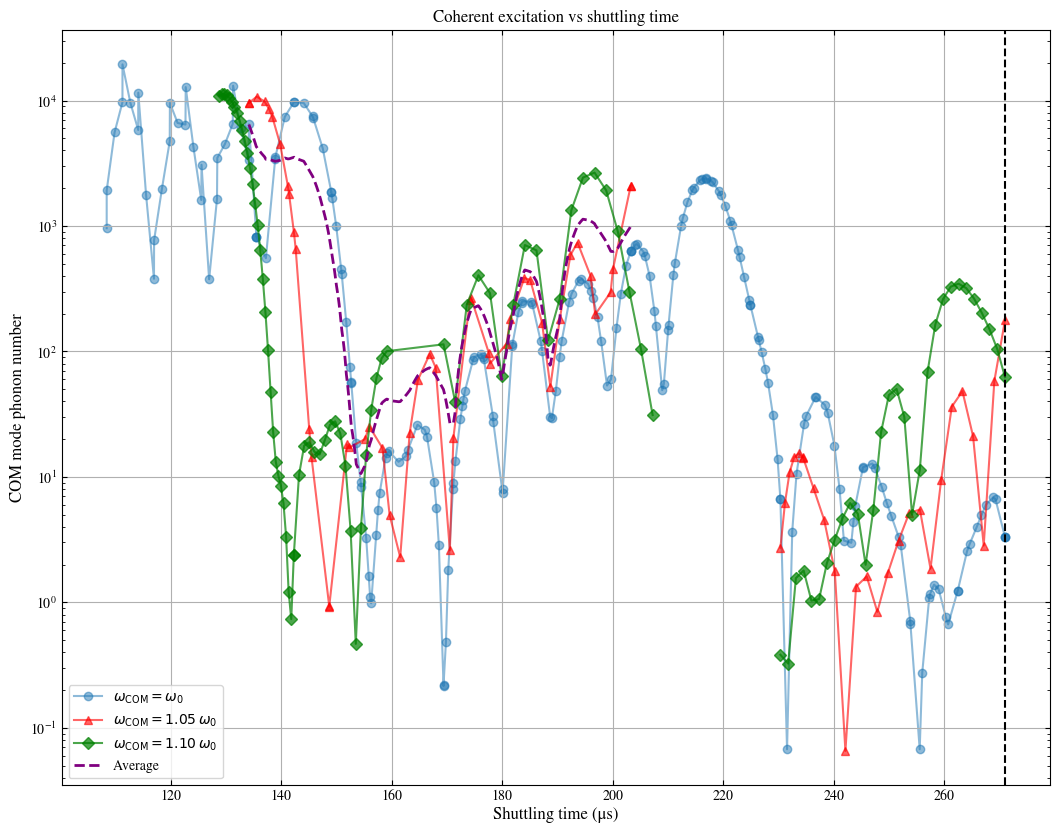

In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update(
    {
        "font.family": "STIXGeneral",
        "xtick.labelsize": 12,
        "xtick.direction": "in",
        "xtick.major.pad": 3,
        "xtick.top": True,
        "ytick.labelsize": 12,
        "ytick.direction": "in",
        "ytick.right": True,
        "axes.labelsize": 12,
        "axes.labelpad": 3,
        "axes.grid": True,
    }
)

# Parameters for the simulation
T_factor = (121 / 133.93969396934) * 1.65  # The time factor for the simulation
NUM_VOLTAGE_POINTS = 500  # The points for voltage sampling
T = 150 * 1e-6 * T_factor  # Total time duration in s unit
points = 3000000  # Number of points at which to evaluate the solution

# Datasets (same as your original code)
# ... (All your phonon_number and shuttling_time arrays) ...

# Merging datasets for the first plot
merged_shuttling_time = np.concatenate(
    (shuttling_time, shuttling_time_1, shuttling_time_2, shuttling_time_3, shuttling_time_4, shuttling_time_5, shuttling_time_6, shuttling_time_10)
)
merged_phonon_number = np.concatenate(
    (phonon_number, phonon_number_1, phonon_number_2, phonon_number_3, phonon_number_4, phonon_number_5, phonon_number_6, phonon_number_10)
)

# Sorting the merged datasets
sorted_pairs = sorted(zip(merged_shuttling_time, merged_phonon_number))
merged_shuttling_time_sorted, merged_phonon_number_sorted = zip(*sorted_pairs)

# Merging datasets for the second plot
merged_shuttling_time_5 = np.concatenate(
    (shuttling_time_11, shuttling_time_12, shuttling_time_13, shuttling_time_14, shuttling_time_15)
)
merged_phonon_number_5 = np.concatenate(
    (phonon_number_11, phonon_number_12, phonon_number_13, phonon_number_14, phonon_number_15)
)
sorted_pairs_5 = sorted(zip(merged_shuttling_time_5, merged_phonon_number_5))
merged_shuttling_time_sorted_5, merged_phonon_number_sorted_5 = zip(*sorted_pairs_5)

# Splitting the second plot data based on a threshold for plotting purposes
merged_shuttling_time_sorted_5_1 = [
    time for time in merged_shuttling_time_sorted_5 if time < 215
]
merged_phonon_number_sorted_5_1 = [
    phonon
    for time, phonon in zip(
        merged_shuttling_time_sorted_5, merged_phonon_number_sorted_5
    )
    if time < 215
]
merged_shuttling_time_sorted_5_2 = [
    time for time in merged_shuttling_time_sorted_5 if time >= 215
]
merged_phonon_number_sorted_5_2 = [
    phonon
    for time, phonon in zip(
        merged_shuttling_time_sorted_5, merged_phonon_number_sorted_5
    )
    if time >= 215
]

# Merging datasets for the third plot
merged_shuttling_time_10 = np.concatenate(
    (shuttling_time_m1, shuttling_time_m2, shuttling_time_m3, shuttling_time_m4)
)
merged_phonon_number_10 = np.concatenate(
    (phonon_number_m1, phonon_number_m2, phonon_number_m3, phonon_number_m4)
)
sorted_pairs_10 = sorted(zip(merged_shuttling_time_10, merged_phonon_number_10))
merged_shuttling_time_sorted_10, merged_phonon_number_sorted_10 = zip(*sorted_pairs_10)

# Splitting the third plot data based on a threshold for plotting purposes
merged_shuttling_time_sorted_10_1 = [
    time for time in merged_shuttling_time_sorted_10 if time < 215
]
merged_phonon_number_sorted_10_1 = [
    phonon
    for time, phonon in zip(
        merged_shuttling_time_sorted_10, merged_phonon_number_sorted_10
    )
    if time < 215
]
merged_shuttling_time_sorted_10_2 = [
    time for time in merged_shuttling_time_sorted_10 if time >= 215
]
merged_phonon_number_sorted_10_2 = [
    phonon
    for time, phonon in zip(
        merged_shuttling_time_sorted_10, merged_phonon_number_sorted_10
    )
    if time >= 215
]

# Plotting settings
half_column_width_inches = 4.25 * 3
aspect_ratio = 1.3  # Desired aspect ratio
plt.figure(
    figsize=(half_column_width_inches, half_column_width_inches / aspect_ratio)
)

# Plotting the three original datasets
plt.plot(
    merged_shuttling_time_sorted,
    merged_phonon_number_sorted,
    marker="o",
    linestyle="-",
    color="C0",
    zorder=0,
    alpha=0.5,
    label="$\omega_{\mathrm{COM}} = \omega_{\mathrm{0}}$",
)
plt.plot(
    merged_shuttling_time_sorted_5_1,
    merged_phonon_number_sorted_5_1,
    marker="^",
    linestyle="-",
    c="red",
    zorder=2,
    alpha=0.6,
    label="$\omega_{\mathrm{COM}} = 1.05 \, \omega_{\mathrm{0}}$",
)
plt.plot(
    merged_shuttling_time_sorted_5_2,
    merged_phonon_number_sorted_5_2,
    marker="^",
    linestyle="-",
    c="red",
    zorder=2,
    alpha=0.6,
)
plt.plot(
    merged_shuttling_time_sorted_10_1,
    merged_phonon_number_sorted_10_1,
    marker="D",
    linestyle="-",
    c="green",
    zorder=2,
    alpha=0.7,
    label="$\omega_{\mathrm{COM}} = 1.10 \, \omega_{\mathrm{0}}$",
)
plt.plot(
    merged_shuttling_time_sorted_10_2,
    merged_phonon_number_sorted_10_2,
    marker="D",
    linestyle="-",
    c="green",
    zorder=2,
    alpha=0.7,
)

# Computing the average plot
# Extracting the datasets for interpolation
time1 = np.array(merged_shuttling_time_sorted)
phonon1 = np.array(merged_phonon_number_sorted)
time2 = np.array(merged_shuttling_time_sorted_5_1)
phonon2 = np.array(merged_phonon_number_sorted_5_1)
time3 = np.array(merged_shuttling_time_sorted_10_1)
phonon3 = np.array(merged_phonon_number_sorted_10_1)

# Computing the overlapping time range
t_min = max(time1.min(), time2.min(), time3.min())
t_max = min(time1.max(), time2.max(), time3.max())

# Creating common time points for interpolation
common_time = np.linspace(t_min, t_max, num=1000)

# Interpolating the phonon numbers onto the common time points
phonon1_interp = np.interp(common_time, time1, phonon1)
phonon2_interp = np.interp(common_time, time2, phonon2)
phonon3_interp = np.interp(common_time, time3, phonon3)

# Computing the average phonon number at each time point
average_phonon = (phonon1_interp + phonon2_interp + phonon3_interp) / 3

# Plotting the average curve
plt.plot(
    common_time,
    average_phonon,
    label="Average",
    color="purple",
    linestyle="--",
    linewidth=2,
)

# Adding labels and title
plt.xlabel("Shuttling time (μs)", fontsize=12)
plt.ylabel("COM mode phonon number", fontsize=12)
plt.title("Coherent excitation vs shuttling time", fontsize=12)
plt.yscale("log")
plt.grid(True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Adding a vertical line for reference
time = 150 * (121 / 133.93969396934) * 2
start = time * 0.995
stop = time * 1.005
plt.axvline(start / 2 + stop / 2, color="black", linestyle="--", alpha=1)

# Saving and showing the plot
pdf_filename = "Phonon_number_vs_shuttling_time_average.pdf"
plt.legend()
plt.savefig(pdf_filename, format="pdf", bbox_inches="tight")
plt.show()
